# DATA PREPARATION

## Importing Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint

# Evaluation
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, auc, recall_score, precision_score, f1_score
from sklearn.feature_selection import chi2

## Defining Functions


### `check_column_type`

In [2]:
def check_column_type(dataframe):
    """
    This function examines the columns of a DataFrame and categorizes them based on their data types.

    Parameters:
    - dataframe: pandas DataFrame, the input DataFrame to be analyzed

    Returns:
    - result_df: pandas DataFrame, a summary of column data types, categorical or numerical nature,
                and range or unique values for each column
    """
    results = []

    # Iterate through each column in the DataFrame
    for column in dataframe.columns:
        # Get data type of the column
        data_type = dataframe[column].dtype

        # Initialize result dictionary
        result = {
            'Column': column,
            'Data Type': data_type,
            'Is Categorical': pd.api.types.is_object_dtype(data_type),
            'Is Numerical': pd.api.types.is_numeric_dtype(data_type),
            'Range/Unique Values': dataframe[column].nunique() if pd.api.types.is_object_dtype(data_type) else (dataframe[column].min(), dataframe[column].max()) if pd.api.types.is_numeric_dtype(data_type) else None
        }

        results.append(result)

    # Create a DataFrame to display the results of checking column data types
    result_df = pd.DataFrame(results)

    return result_df

### `check_missing_values`

In [3]:
def check_missing_values(dataframe):
    """
    Check for missing values in a DataFrame.

    Parameters:
    - dataframe: pd.DataFrame

    Returns:
    - missing_values_df: pd.DataFrame, a DataFrame showing the total missing values and the percentage of missing values
    """
    # Create a DataFrame to show the total missing values and percentage
    missing_values_df = pd.DataFrame({
        'Column': dataframe.columns,
        'Total Missing Values': dataframe.isnull().sum(),
        'Percentage': dataframe.isnull().mean() * 100
    })

    missing_values_df = missing_values_df.sort_values(by='Percentage', ascending=False).reset_index(drop=True)

    return missing_values_df

### `plot_cat_dist`

In [4]:
def plot_cat_dist(df, column_name, target_value='With Payment Difficulties'):
    """
    Plot the distribution of a categorical column in the entire dataset and a subset based on the target value.

    Parameters:
    - df: pd.DataFrame, dataset with or without payment difficulty
    - column_name (str): column name for plotting
    - target_value (str): target value for creating the subset (default is 'With Payment Difficulties')
    """
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))

    # Sort the values in the column for the entire dataset
    sorted_values = df[column_name].value_counts().index

    # Plot for the entire dataset with sorted values
    sns.countplot(data=df, x=column_name, order=sorted_values, ax=ax[0], palette='viridis')
    ax[0].set_xlabel(column_name)
    ax[0].set_ylabel("Count")

    total_data = len(df[column_name])
    for p in ax[0].patches:
        height = p.get_height()
        ax[0].annotate(f'{height/total_data:.1%}', (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    # Sort the values in the column for the subset where the target is the specified value
    sorted_values_subset = df[df['TARGET'] == target_value][column_name].value_counts().index

    # Plot for the subset with sorted values
    sns.countplot(data=df[df['TARGET'] == target_value], x=column_name, order=sorted_values_subset, ax=ax[1], palette='viridis')
    ax[1].set_xlabel(column_name)
    ax[1].set_ylabel(f"Count with {target_value}")

    total_data_subset = len(df[df['TARGET'] == target_value][column_name])
    for p in ax[1].patches:
        height = p.get_height()
        ax[1].annotate(f'{height/total_data_subset:.1%}', (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    # Rotate x-axis labels if there are more than 5 categories
    if len(sorted_values) > 5:
        plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45, ha="right")
    if len(sorted_values_subset) > 5:
        plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45, ha="right")

    # Add a title to the entire subplot
    plt.suptitle(f"Comparison of {column_name} Distribution", y=1.05, fontsize=16)

    sns.despine()
    plt.tight_layout()
    plt.show()

### `plot_num_dist`

In [5]:
def plot_num_dist(df, column_name, duration=None):
    """
    Plot the distribution of a numerical column, optionally adjusting values based on duration.

    Parameters:
    - df: pd.DataFrame, input DataFrame
    - column_name (str): the column to plot
    - duration (str): optional, 'year' or 'month' to adjust values accordingly
    """
    # Create a copy of the DataFrame to avoid modifying the original DataFrame
    df_copy = df.copy()

    # Adjust values based on duration
    if duration == 'year':
        df_copy[column_name] /= 365
        xlabel = f"{column_name} (Years)"
    elif duration == 'month':
        df_copy[column_name] /= 30
        xlabel = f"{column_name} (Months)"
    else:
        xlabel = f"{column_name}"

    # Create a figure with specified size
    plt.figure(figsize=(10, 6))

    # Plot the distribution using seaborn's histplot
    sns.histplot(df_copy[column_name], kde=False, edgecolor="k", linewidth=0.5, color='navy', bins= 30)
    plt.title(f"Distribution of {column_name}", y=1.05)
    plt.xlabel(xlabel)
    plt.ylabel("Count")

    # Add lines for median, maximum, and minimum values
    median_value = df_copy[column_name].median()
    max_value = df_copy[column_name].max()
    min_value = df_copy[column_name].min()
    plt.axvline(median_value, color='orange', linestyle='dashed', linewidth=2, label=f'Median Value: {median_value:,.2f}')
    plt.axvline(max_value, color='red', linestyle='dashed', linewidth=2, label=f'Max Value: {max_value:,.2f}')
    plt.axvline(min_value, color='green', linestyle='dashed', linewidth=2, label=f'Min Value: {min_value:,.2f}')
    plt.legend()

    # Remove top and right spines for aesthetic purposes
    sns.despine()
    plt.show()


### `detect_outliers_iqr`

In [6]:
def detect_outliers_iqr(df):
    """
    Detect outliers in a DataFrame using the IQR method.

    Parameters:
    - df: pd.DataFrame, dataset to be analyzed.

    Returns:
    - outliers_df: pd.DataFrame, outlier detection results with columns "column_name",
                   "number_of_outliers", and "percentage".
    """
    outliers_data = []

    for column in df.columns:
        # Calculate quartiles and IQR
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1

        # Define lower and upper bounds
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Detect outliers outside lower and upper bounds
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

        # Calculate the number of outliers and percentage
        num_outliers = len(outliers)
        percentage_outliers = (num_outliers / len(df)) * 100

        outliers_data.append({'column_name': column, 'number_of_outliers': num_outliers, 'percentage': percentage_outliers})

    outliers_df = pd.DataFrame(outliers_data)

    return outliers_df


### `visualize_outliers`

In [7]:
def visualize_outliers(dataframe, columns, n_rows, n_cols):
    """
    Visualize outliers in a DataFrame using boxplots.

    Parameters:
    - dataframe: pd.DataFrame, the dataset to be visualized.
    - columns: List, columns to be visualized.
    - n_rows: int, number of subplot rows.
    - n_cols: int, number of subplot columns.

    Returns:
    - None: Displays boxplot subplots.
    """

    # Calculate the number of subplots
    total_subplots = n_rows * n_cols

    # Check whether the number of columns exceeds the number of available subplots
    if len(columns) < total_subplots:
        print("The number of columns is less than the total requested subplots.")
        return

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 7))
    fig.tight_layout(pad=3.0)

    for i in range(total_subplots):
        # Ensure not to create more subplots than the required number of columns
        if i < len(columns):
            col = columns[i]

            # Check whether the subplot is a one-dimensional or two-dimensional matrix
            if n_rows > 1 and n_cols > 1:
                sns.boxplot(y=dataframe[col], ax=axes[i // n_cols, i % n_cols], orient='h')
                axes[i // n_cols, i % n_cols].set_title(col)
            else:
                sns.boxplot(y=dataframe[col], ax=axes[i], orient='h')
                axes[i].set_title(col)

    plt.tight_layout()
    plt.show()


### `extract_columns`

In [8]:
def extract_columns(df):
    """
    Extract numerical and categorical columns from a DataFrame excluding specified columns.

    Parameters:
    - df: pd.DataFrame, the input DataFrame.

    Returns:
    - numerical_columns: pd.Index, numerical columns excluding 'SK_ID_CURR' and 'TARGET'.
    - categorical_columns: pd.Index, categorical columns excluding 'SK_ID_CURR' and 'TARGET'.
    """
    # Exclude 'SK_ID_CURR' and 'TARGET'
    excluded_columns = ['SK_ID_CURR', 'TARGET']

    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
    numerical_columns = numerical_columns[~numerical_columns.isin(excluded_columns)]

    categorical_columns = df.select_dtypes(include=['object']).columns
    categorical_columns = categorical_columns[~categorical_columns.isin(excluded_columns)]

    return numerical_columns, categorical_columns


### `train_model`

In [9]:
def train_model(X_train, X_test, y_train, y_test, model='logistic', params=None):
    """
    Train a machine learning model using the specified data and model.

    Parameters:
    - X_train: DataFrame, training features
    - X_test: DataFrame, testing features
    - y_train: Series, training target
    - y_test: Series, testing target
    - model: string, choice of model ('logistic', 'xgb', 'lgbm', 'decision_tree', 'random_forest', 'naive_bayes')
    - params: dict, optional parameters for the model (default=None)

    Returns:
    - trained_model: trained machine learning model
    - y_pred_proba: predicted probabilities for the positive class
    - y_true: true labels
    - y_pred: predicted labels
    """

    # Select the model based on the input
    if model == 'logistic':
        base_model = LogisticRegression(**params) if params else LogisticRegression()
    elif model == 'decision_tree':
        base_model = DecisionTreeClassifier(**params) if params else DecisionTreeClassifier()
    elif model == 'random_forest':
        base_model = RandomForestClassifier(**params) if params else RandomForestClassifier()
    elif model == 'xgb':
        base_model = XGBClassifier(**params) if params else XGBClassifier()
    elif model == 'lgbm':
        base_model = LGBMClassifier(**params) if params else LGBMClassifier()
    else:
        raise ValueError("Invalid model. Choose from 'logistic', 'decision_tree', 'random_forest', 'xgb', 'lgbm'.")

    # Train the model
    base_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_proba = base_model.predict_proba(X_test)[:, 1]
    y_pred = base_model.predict(X_test)

    # Calculate accuracy and AUC score
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Print the evaluation metrics
    print(f"Accuracy of {model} model: {accuracy:.4f}")
    print(f"AUC score of {model} model: {auc_score:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    return base_model, y_pred_proba, y_test, y_pred

### `plot_confusion_matrix`

In [10]:
def plot_confusion_matrix(y_true, y_pred, classes=None, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    Plot a confusion matrix.

    Parameters:
    - y_true: true labels
    - y_pred: predicted labels
    - classes: array-like, shape (n_classes,), optional (default=None)
    - normalize: bool, optional (default=False)
        If True, normalize the confusion matrix.
    - title: str, optional (default=None)
        Title of the plot.
    - cmap: matplotlib colormap, optional (default=plt.cm.Blues)
        Colormap to use for the plot.

    Returns:
    - None
    """

    if classes is None:
        classes = unique_labels(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'

    plt.figure(figsize=(8, 8))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title if title else 'Confusion Matrix')
    plt.show()

### `plot_roc_curve`

In [11]:
def plot_roc_curve(y_true, y_pred_proba, model_name='Model'):
    """
    Plot the ROC AUC curve.

    Parameters:
    - y_true: true labels
    - y_pred_proba: predicted probabilities for the positive class
    - model_name: string, name of the model (default='Model')
    """

    # Compute ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

## Loading Dataset

In [12]:
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')

In [13]:
app_train.sample(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
170913,298073,0,Cash loans,F,N,N,0,171000.0,239850.0,23850.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
198728,330415,0,Cash loans,F,Y,N,0,270000.0,508495.5,20295.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
98633,214525,0,Revolving loans,F,N,N,0,90000.0,247500.0,12375.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
app_test.sample(3)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
46222,437892,Cash loans,F,N,Y,0,180000.0,906700.5,29380.5,634500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,2.0
1784,112677,Cash loans,F,Y,Y,0,216000.0,900000.0,50256.0,900000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
21887,258832,Cash loans,M,N,N,0,112500.0,148140.0,7123.5,112500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# EDA

## Checking the Structure of Datasets

### Datasets's Shape

In [15]:
print("app_train             :", app_train.shape)
print("app_test              :", app_test.shape)

app_train             : (307511, 122)
app_test              : (48744, 121)


There are 307,511 observations and 122 columns in app_train. In contrast, app_test has a total of 121 columns, excluding the 'TARGET' column present in app_train.

### Datasets's Info

In [16]:
check_column_type(app_train)

,Column,Data Type,Is Categorical,Is Numerical,Range/Unique Values
0,SK_ID_CURR,int64,False,True,"(100002, 456255)"
1,TARGET,int64,False,True,"(0, 1)"
2,NAME_CONTRACT_TYPE,object,True,False,2
3,CODE_GENDER,object,True,False,3
4,FLAG_OWN_CAR,object,True,False,2
5,FLAG_OWN_REALTY,object,True,False,2
6,CNT_CHILDREN,int64,False,True,"(0, 19)"
7,AMT_INCOME_TOTAL,float64,False,True,"(25650.0, 117000000.0)"
8,AMT_CREDIT,float64,False,True,"(45000.0, 4050000.0)"
9,AMT_ANNUITY,float64,False,True,"(1615.5, 258025.5)"


The table above shows columns related to time information with negative values. To enhance interpretability, these columns will be converted to positive.

In [17]:
# Change negative values in days-related columns to make it more interpretable
days_columns= ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE']

app_train[days_columns]= abs(app_train[days_columns])

In [18]:
# Test data treatment
app_test[days_columns]= abs(app_test[days_columns])

## Checking Missing Values

In [19]:
check_missing_values(app_train)

,Column,Total Missing Values,Percentage
0,COMMONAREA_MEDI,214865,69.872297
1,COMMONAREA_AVG,214865,69.872297
2,COMMONAREA_MODE,214865,69.872297
3,NONLIVINGAPARTMENTS_MODE,213514,69.432963
4,NONLIVINGAPARTMENTS_AVG,213514,69.432963
5,NONLIVINGAPARTMENTS_MEDI,213514,69.432963
6,FONDKAPREMONT_MODE,210295,68.386172
7,LIVINGAPARTMENTS_MODE,210199,68.354953
8,LIVINGAPARTMENTS_AVG,210199,68.354953
9,LIVINGAPARTMENTS_MEDI,210199,68.354953


Columns with over 60% missing values will be deleted, and missing values in the other columns will be imputed.

###  Dropping Columns with High Number of Missing Values

In [20]:
# Set the threshold percentage for missing values
threshold_percentage = 60

# Calculate the threshold count based on the percentage
threshold_count = (threshold_percentage / 100) * len(app_train)

# Identify columns with missing values count above the threshold
columns_to_drop = app_train.columns[app_train.isnull().sum() > threshold_count]

# Drop the identified columns
app_train = app_train.drop(columns=columns_to_drop)

In [21]:
# Test data treatment
app_test = app_test.drop(columns=columns_to_drop)

### Imputing Missing Values

Missing values in categorical columns will be filled with the mode, and numeric columns will be filled using the median.

In [22]:
# Dividing columns based on datatype
numerical_columns, categorical_columns = extract_columns(app_train)

# Imputing missing values with mode and median
app_train[numerical_columns] = app_train[numerical_columns].fillna(app_train[numerical_columns].median())
app_train[categorical_columns] = app_train[categorical_columns].fillna(app_train[categorical_columns].mode().iloc[0])

In [23]:
# Test data treatment
app_test[numerical_columns] = app_test[numerical_columns].fillna(app_test[numerical_columns].median())
app_test[categorical_columns] = app_test[categorical_columns].fillna(app_test[categorical_columns].mode().iloc[0])

In [24]:
# Check missing values
check_missing_values(app_train)

,Column,Total Missing Values,Percentage
0,SK_ID_CURR,0,0.0
1,BASEMENTAREA_MODE,0,0.0
2,DEF_60_CNT_SOCIAL_CIRCLE,0,0.0
3,OBS_60_CNT_SOCIAL_CIRCLE,0,0.0
4,DEF_30_CNT_SOCIAL_CIRCLE,0,0.0
5,OBS_30_CNT_SOCIAL_CIRCLE,0,0.0
6,EMERGENCYSTATE_MODE,0,0.0
7,WALLSMATERIAL_MODE,0,0.0
8,TOTALAREA_MODE,0,0.0
9,HOUSETYPE_MODE,0,0.0


In [25]:
print("Train data shape after columns with high number of missing values removal: ", app_train.shape)
print("Test data shape after columns with high number of missing values removal: ", app_test.shape)

Train data shape after columns with high number of missing values removal:  (307511, 105)
Test data shape after columns with high number of missing values removal:  (48744, 104)


## Checking Duplicated Values

In [26]:
print('app_train             : ', app_train.duplicated().sum())
print('app_test              : ', app_train.duplicated().sum())

app_train             :  0
app_test              :  0


Fortunately, there are no duplicate rows in the datasets, so there is no need for further handling.

## Checking Outliers

Among all the columns in the dataset, not all numeric columns are checked for outliers. This is because some columns contain binary values, are the result of normalization, or have small ranges.

In [27]:
# Numeric columns that will be checked for outliers
outlier_columns= ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH',
                  'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OBS_30_CNT_SOCIAL_CIRCLE',
                  'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
                  'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
                  'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
                  'AMT_REQ_CREDIT_BUREAU_YEAR']

detect_outliers_iqr(app_train[outlier_columns])

,column_name,number_of_outliers,percentage
0,AMT_INCOME_TOTAL,14035,4.564064
1,AMT_CREDIT,6562,2.133907
2,AMT_ANNUITY,7504,2.440238
3,AMT_GOODS_PRICE,14728,4.789422
4,DAYS_BIRTH,0,0.000000
5,DAYS_EMPLOYED,56357,18.326824
6,DAYS_REGISTRATION,659,0.214301
7,DAYS_ID_PUBLISH,0,0.000000
8,OBS_30_CNT_SOCIAL_CIRCLE,19971,6.494402
9,DEF_30_CNT_SOCIAL_CIRCLE,35166,11.435688


### Visualizing Outliers

To further detect whether the outliers are still acceptable or too extreme, let's plot them.

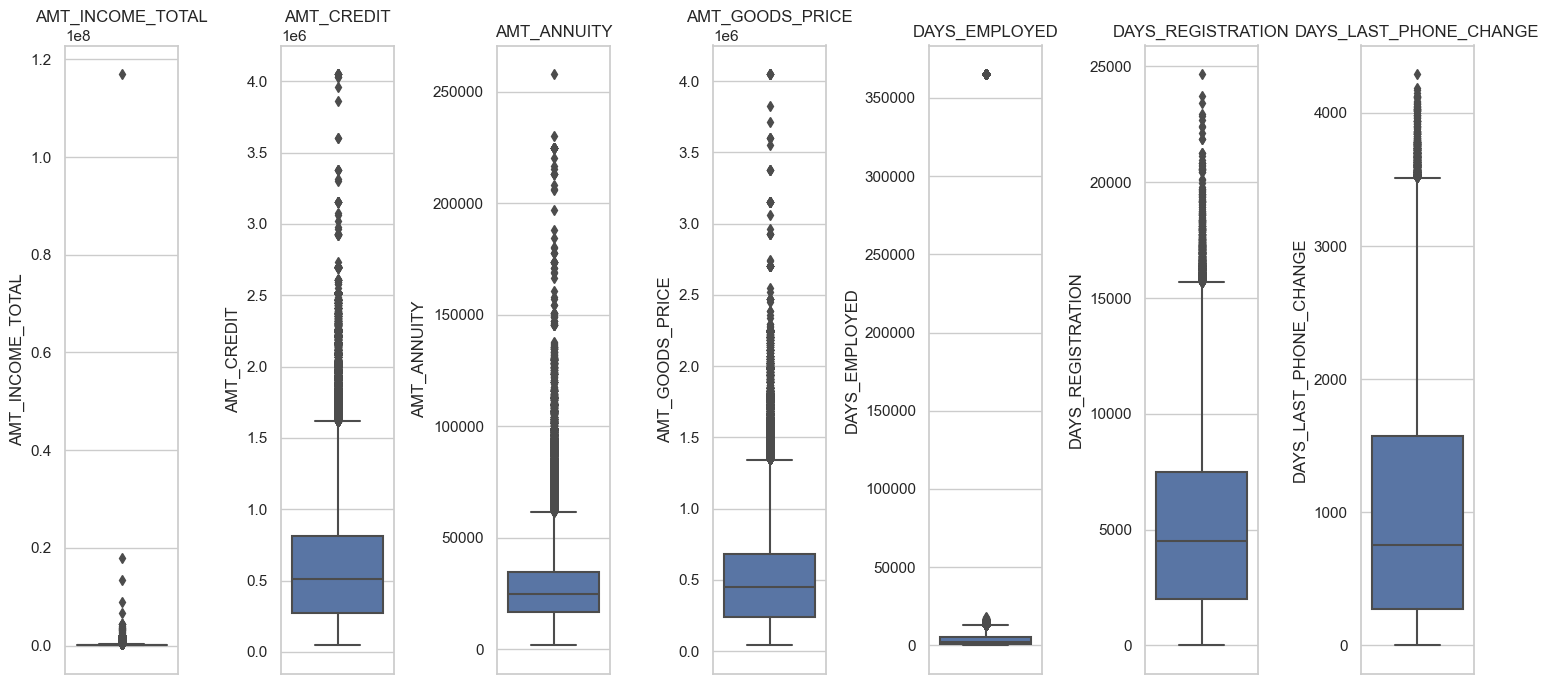

In [28]:
col_list_1= ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
             'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE']

visualize_outliers(app_train, col_list_1, 1, 7)

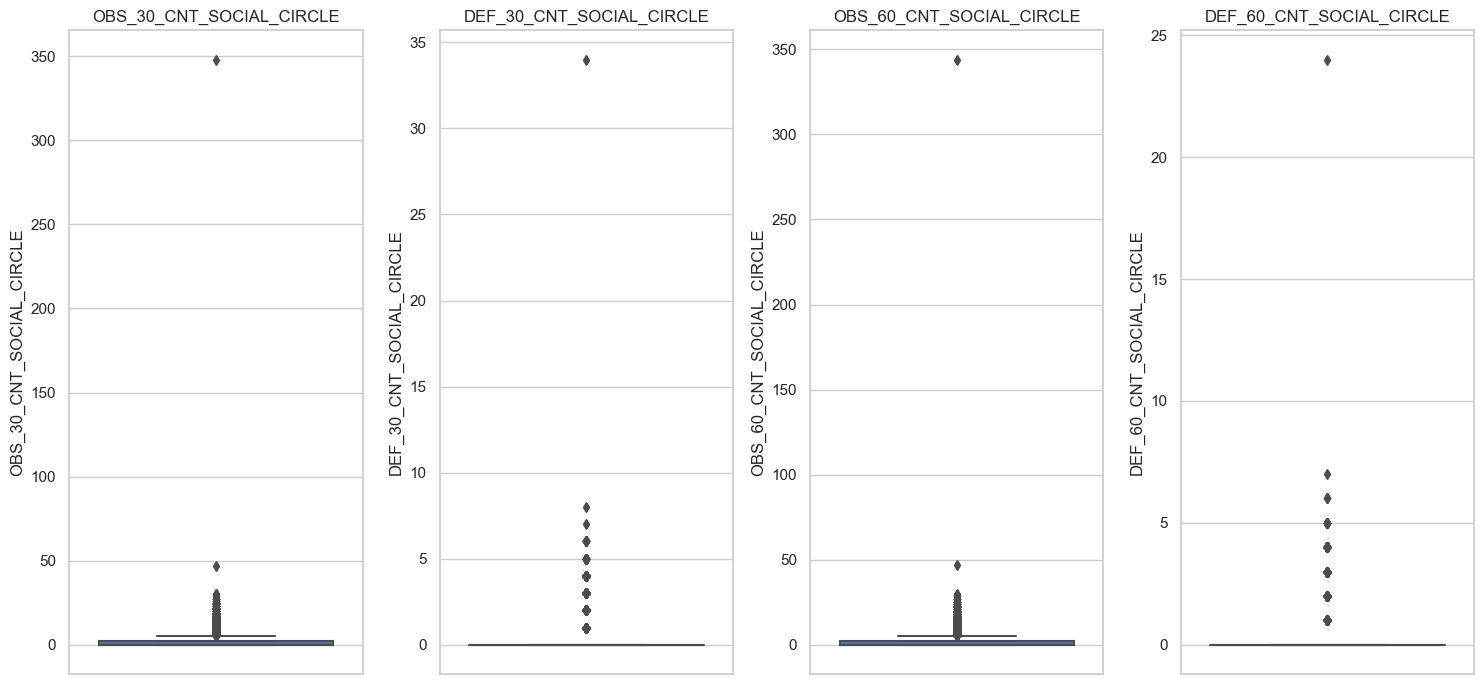

In [29]:
col_list_2= ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']

visualize_outliers(app_train, col_list_2, 1, 4)

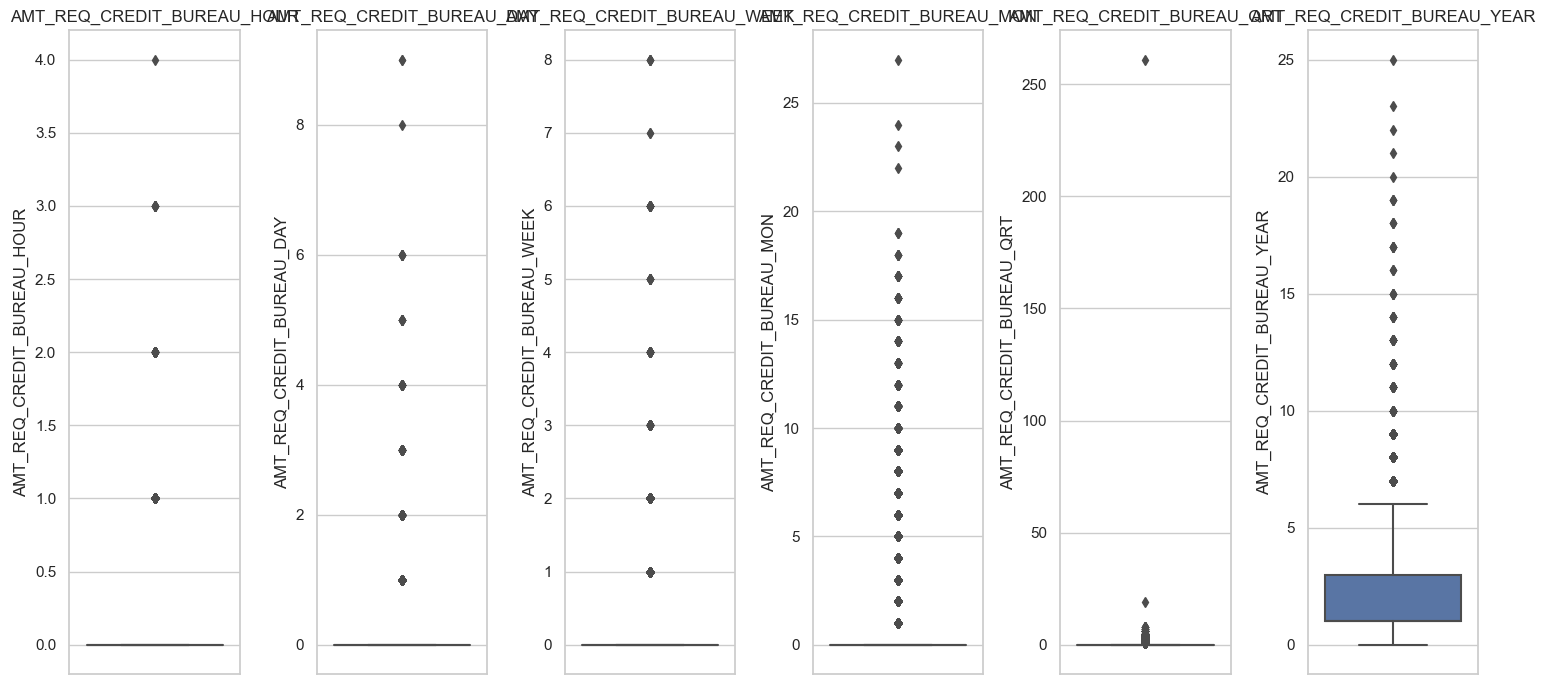

In [30]:
col_list_3= ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
             'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

visualize_outliers(app_train, col_list_3, 1, 6)

From the plot above, it can be seen that columns 'AMT_INCOME_TOTAL' and 'DAYS_EMPLOYED' contains extreme outliers, likely due to data input errors. Consequently, outliers in these two columns will be addressed. However, outliers in other columns will not be removed as their values remain reasonable relative to the column value range.

### Extreme Outliers Removal

The 'DAYS_EMPLOYED' column contains 56,357 outliers, constituting 18.32% of the total observations. These outliers likely indicate borrowers who are past retirement age. To confirm this, I will examine whether the corresponding values in the 'NAME_INCOME_TYPE' column are labeled as 'Pensioner'.

In [31]:
app_train[(app_train['DAYS_EMPLOYED'] > 350000) & (app_train['NAME_INCOME_TYPE'] == 'Pensioner')]['SK_ID_CURR'].count()

55352

Indeed, the majority of these outliers are retirees, indicating a data input error. Consequently, I will replace these values with 18,250, roughly equivalent to 50 years, as I assume this value represents the typical employment duration until retirement. As for other outlier values, I will proceed to remove them.

In [32]:
app_train['AMT_INCOME_TOTAL'].describe()

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

The 'AMT_INCOME_TOTAL' column displays a broad range of values, spanning from 25,650 to a maximum of 117 million. The distribution appears positively skewed, indicating that the majority of values are concentrated below 200,000. However, there is an outlier with a value exceeding 100 million, which seems unusually high and may negatively impact the analysis. Therefore, values above 100 million will be removed to ensure a more accurate representation of the income distribution.

In [33]:
# Identify rows where 'DAYS_EMPLOYED' is greater than 350,000 and 'NAME_INCOME_TYPE' is 'Pensioner'
criteria = (app_train['DAYS_EMPLOYED'] > 350000) & (app_train['NAME_INCOME_TYPE'] == 'Pensioner')

# Replace 'DAYS_EMPLOYED' values with 18,250 for rows that meet the criteria
app_train.loc[criteria, 'DAYS_EMPLOYED'] = 18250

# Filter out extreme outliers
app_train = app_train[(app_train['AMT_INCOME_TOTAL'] <= 100000000) & (app_train['DAYS_EMPLOYED'] <= 350000)]

In [34]:
# Test data treatment
app_test.loc[criteria, 'DAYS_EMPLOYED'] = 18250

app_test = app_test[(app_test['AMT_INCOME_TOTAL'] <= 100000000) & (app_test['DAYS_EMPLOYED'] <= 350000)]

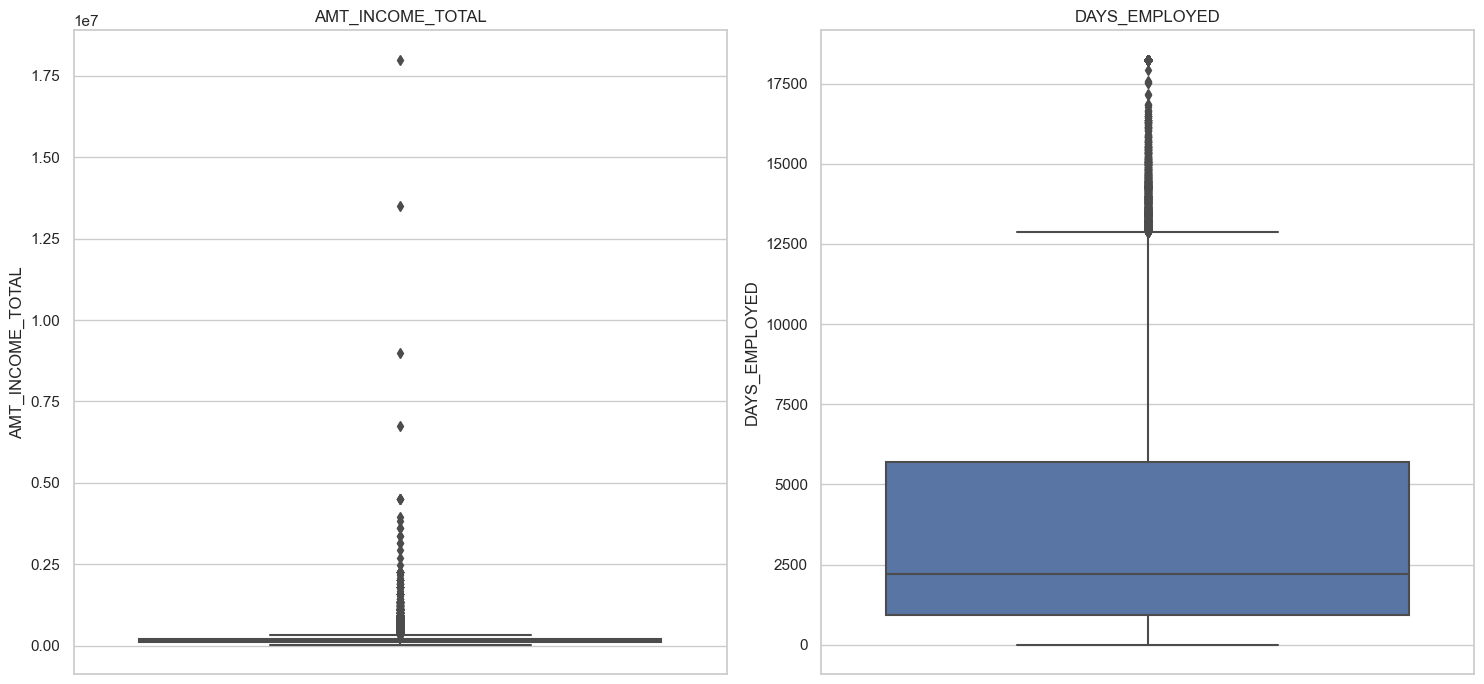

In [35]:
visualize_outliers(app_train, ['AMT_INCOME_TOTAL', 'DAYS_EMPLOYED'], 1, 2)

In [36]:
print("Train data shape after extreme outliers removal: ", app_train.shape)
print("Test data shape after extreme outliers removal: ", app_test.shape)

Train data shape after extreme outliers removal:  (307488, 105)
Test data shape after extreme outliers removal:  (41138, 104)


In [37]:
# Importing clean dataset for checkpoint
app_train.to_csv('app_train_clean.csv', index= False)
app_test.to_csv('app_test_clean.csv', index= False)

## Data Visulization

To make interpretation easier, I will change the values 1 and 0 in the 'TARGET' column to 'With Payment Difficulties' and 'Without Payment Difficulties'.

In [38]:
app_train_eda= app_train.copy()

In [39]:
# Change 'TARGET' value for better interpretation
app_train_eda['TARGET']= app_train_eda['TARGET'].apply(lambda x: 'With Payment Difficulties' if x == 1 else 'Without Payment Difficulties')

### Type of Loan

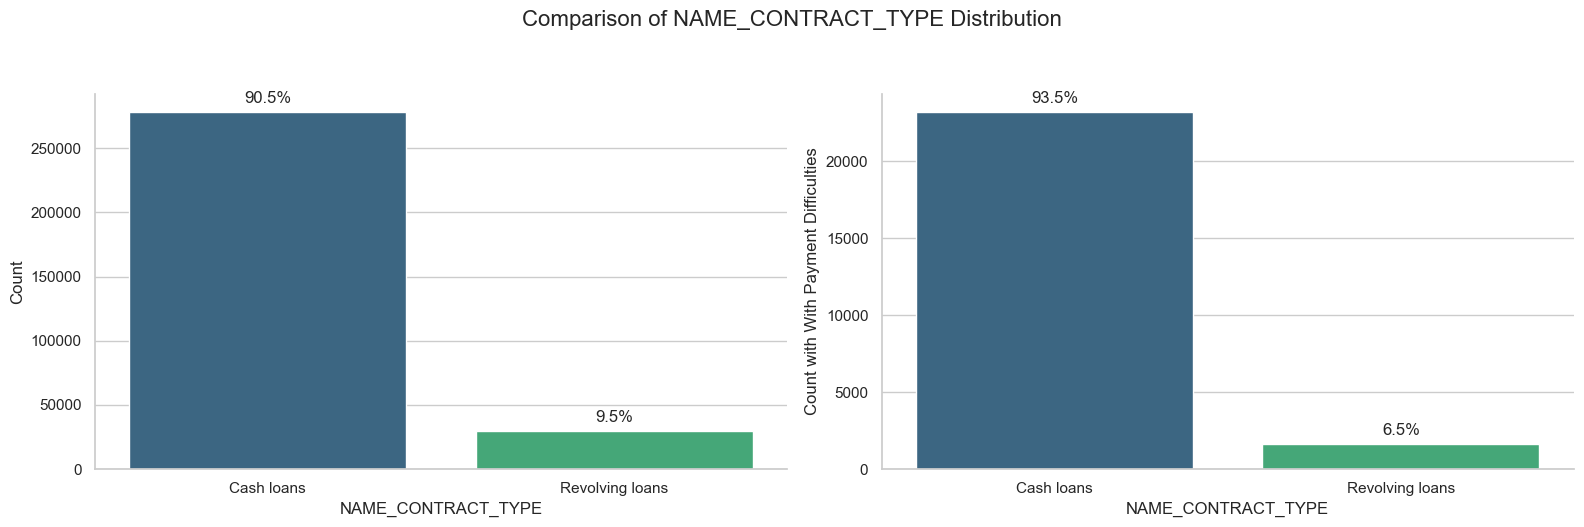

In [40]:
# Plot 'NAME_CONTRACT_TYPE'
plot_cat_dist(app_train_eda, 'NAME_CONTRACT_TYPE')

Overall, the majority of borrowers opt for cash loans, indicating a preference for this type of financing.
However, when focusing on instances with payment difficulties, the percentage of borrowers facing challenges is higher among those with cash loans (93.5%), suggesting that payment difficulties are more prevalent in this category.

Revolving loans, while constituting a smaller portion of the overall loans, still contribute to a noteworthy 6.5% of cases with payment difficulties. This implies that, although less common overall, individuals with revolving loans also experience challenges in repayment.

### Gender

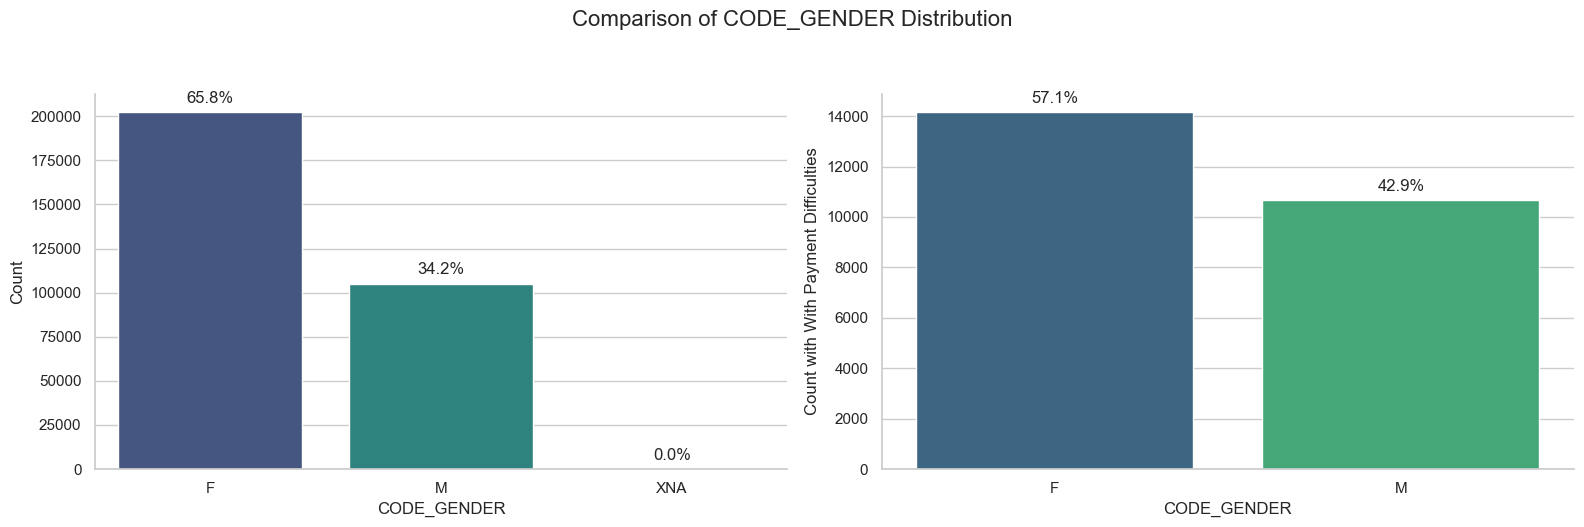

In [41]:
# Plot 'CODE_GENDER'
plot_cat_dist(app_train_eda, 'CODE_GENDER')

In the overall dataset, female borrowers significantly outnumber male borrowers.
However, when examining cases with payment difficulties, the proportion of females facing challenges is lower than their overall representation, indicating a slightly lower vulnerability to payment difficulties compared to males.

Male borrowers, although constituting a smaller portion of the overall borrowers, contribute more significantly to cases with payment difficulties, suggesting a higher likelihood of encountering repayment challenges compared to females.

### Car & Realty Ownership

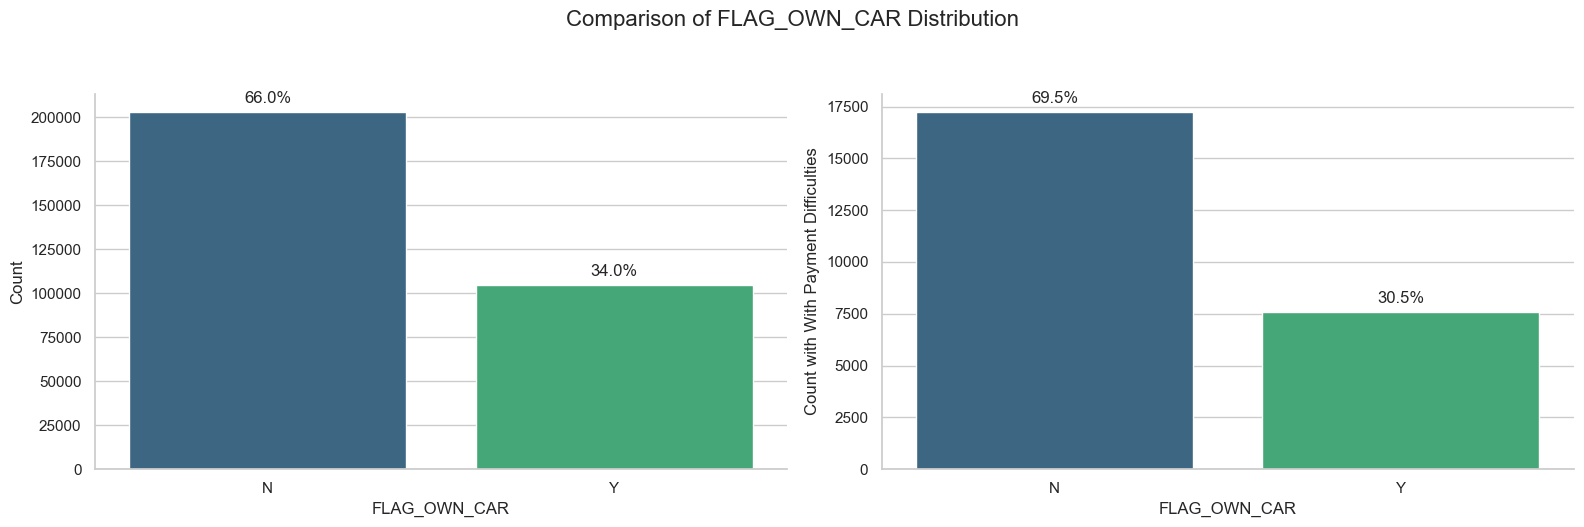

In [42]:
# Plot 'FLAG_OWN_CAR'
plot_cat_dist(app_train_eda, 'FLAG_OWN_CAR')

Borrowers who do not own a car constitute the majority of the borrower population at 66%.

Among cases with payment difficulties, individuals without car ownership show a higher prevalence at 69.5%, indicating that individuals without a car are experiencing challenges in repayment at a relatively higher rate.

Borrowers with car ownership, while representing a smaller share in the overall borrower population, contribute less to cases with payment difficulties, suggesting a relatively lower likelihood of encountering repayment challenges compared to those without car ownership.

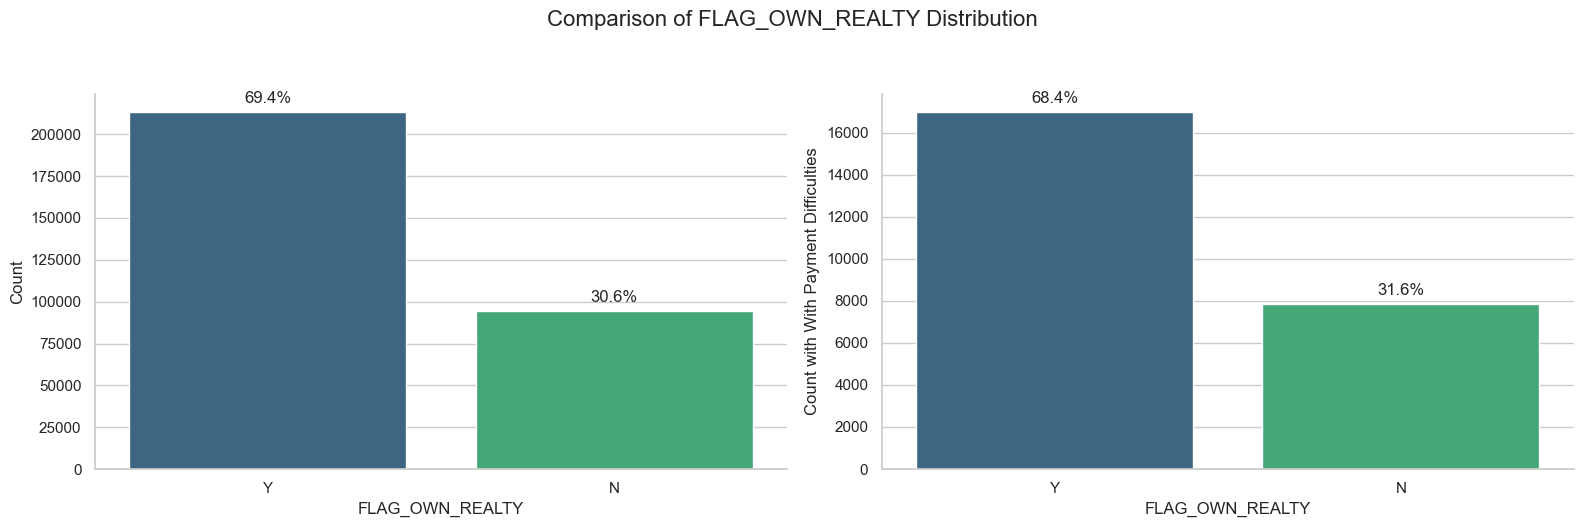

In [43]:
# Plot 'FLAG_OWN_REALTY'
plot_cat_dist(app_train_eda, 'FLAG_OWN_REALTY')

The majority of borrowers, at 69.4%, own realty.

Among cases with payment difficulties, individuals without realty ownership show a slightly higher prevalence at 31.6%, indicating that individuals without realty ownership are experiencing challenges in repayment at a slightly elevated rate.

Borrowers with realty ownership, while representing a larger share in the overall borrower population, contribute less to cases with payment difficulties, suggesting a relatively lower likelihood of encountering repayment challenges compared to those without realty ownership.

### Housing Type

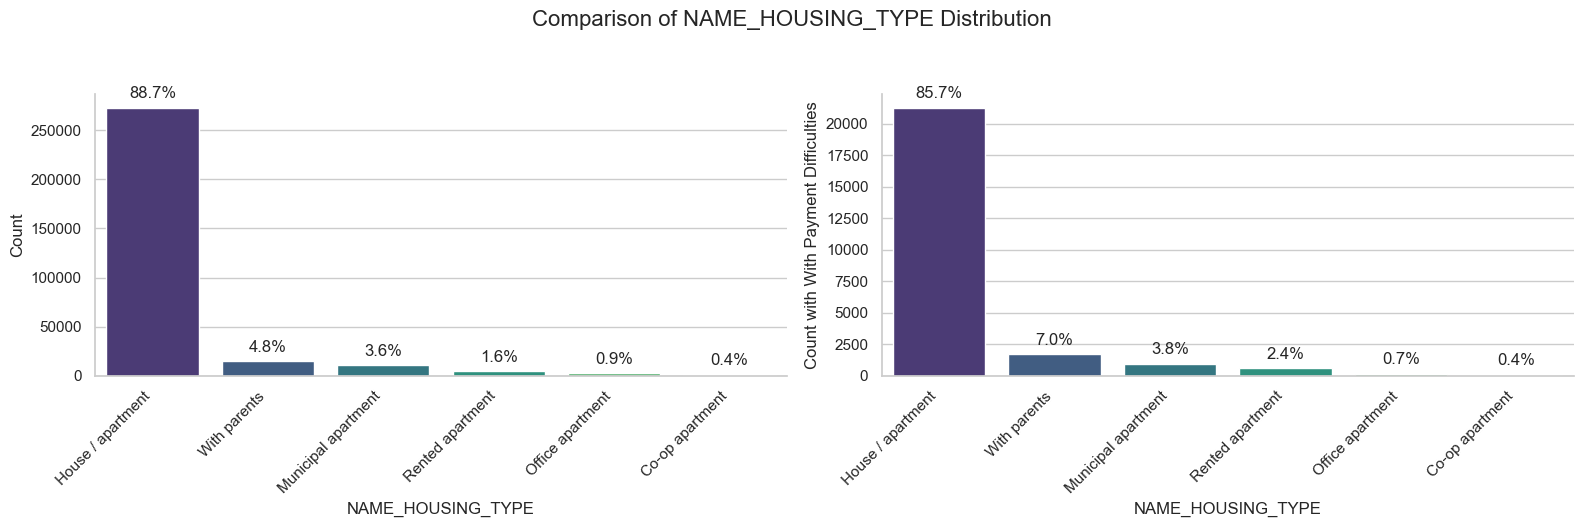

In [44]:
# Plot 'NAME_HOUSING_TYPE'
plot_cat_dist(app_train_eda, 'NAME_HOUSING_TYPE')

The most common housing type among borrowers is a house/apartment, making up the majority at 88.7%.

Despite being the most prevalent housing type, individuals living in a house/apartment exhibit a slightly lower percentage of payment difficulties, indicating a relatively lower likelihood of encountering repayment challenges compared to other housing types.

Other housing types, such as living with parents, municipal apartment, rented apartment, office apartment, and co-op apartment, collectively constitute a smaller portion in both the overall borrower population and cases with payment difficulties.

### Family Circumstances

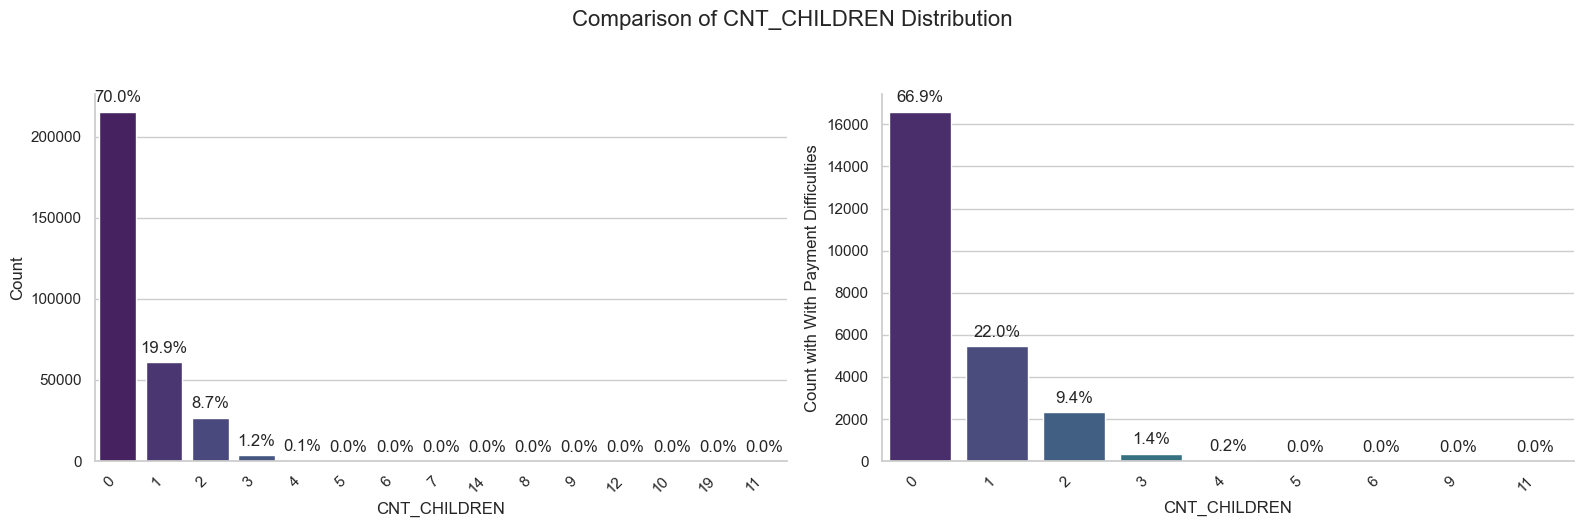

In [45]:
# Plot 'CNT_CHILDREN'
plot_cat_dist(app_train_eda, 'CNT_CHILDREN')

Borrowers without children constitute the largest group, making up 70% of the borrower population.

Despite being the most common, borrowers without children show a slightly lower percentage of payment difficulties, indicating a relatively lower likelihood of encountering repayment challenges compared to borrowers with children.

Borrowers with 1 or 2 children contribute to a significant portion of the borrower population and cases with payment difficulties.
Borrowers with 3 children, while representing the smallest portion, also contribute to cases with payment difficulties, albeit at a minimal percentage.

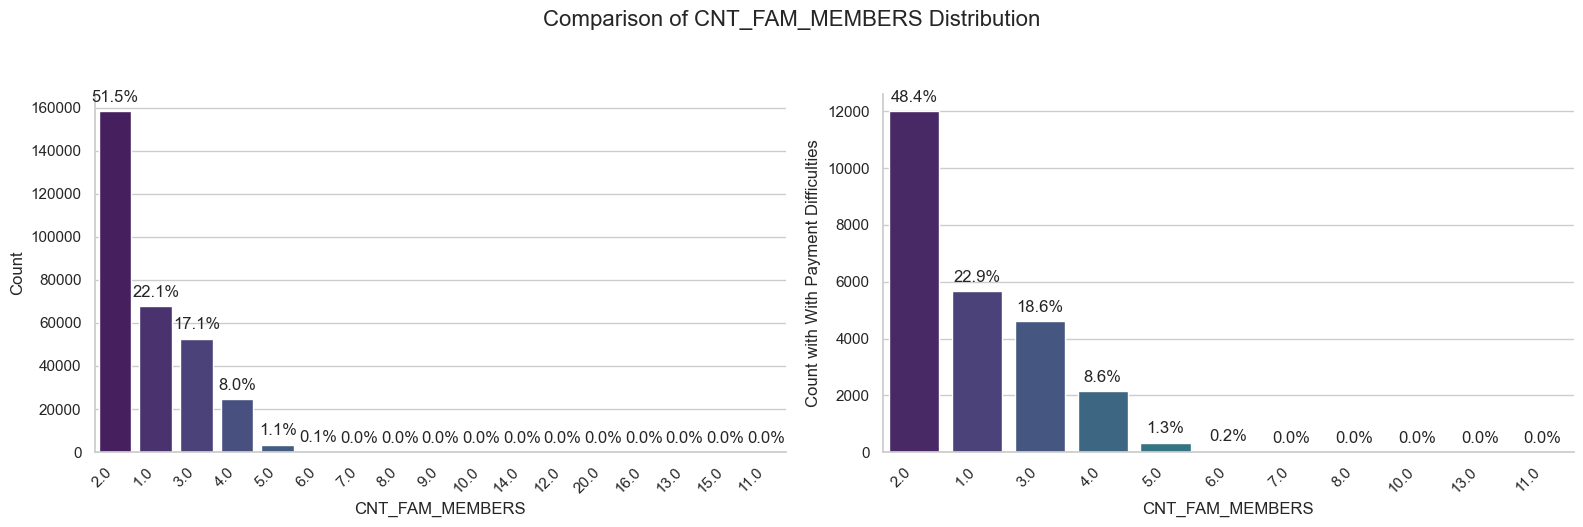

In [46]:
# Plot 'CNT_FAM_MEMBERS'
plot_cat_dist(app_train_eda, 'CNT_FAM_MEMBERS')

Borrowers with 2 family members constitute the majority, making up 51.5% of the borrower population.

Despite being the most common, borrowers with 2 family members show a slightly lower percentage of payment difficulties, indicating a relatively lower likelihood of encountering repayment challenges compared to borrowers with other family sizes.

Borrowers with 1, 3, and 4 family members contribute significantly to the borrower population and cases with payment difficulties.

Borrowers with 5 family members, while representing the smallest portion, also contribute to cases with payment difficulties, albeit at a minimal percentage.

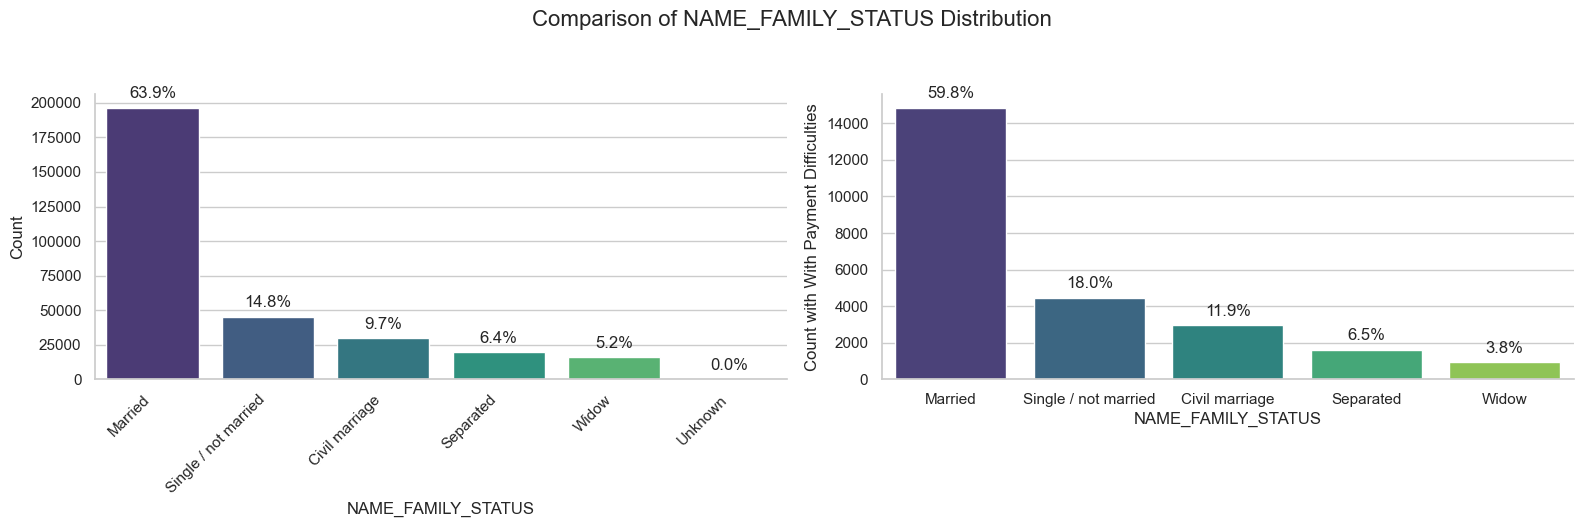

In [47]:
# Plot 'NAME_FAMILY_STATUS'
plot_cat_dist(app_train_eda, 'NAME_FAMILY_STATUS')

Married individuals constitute the majority of borrowers, making up 63.9% of the borrower population.

Despite being the most common family status, married individuals show a slightly lower percentage of payment difficulties, indicating a relatively lower likelihood of encountering repayment challenges compared to borrowers with other family statuses.

Single, civil marriage, separated, and widow borrowers contribute significantly to both the borrower population and cases with payment difficulties.

Widow borrowers, while representing the smallest portion, also contribute to cases with payment difficulties, albeit at a minimal percentage.

### Amount of Income Distribution

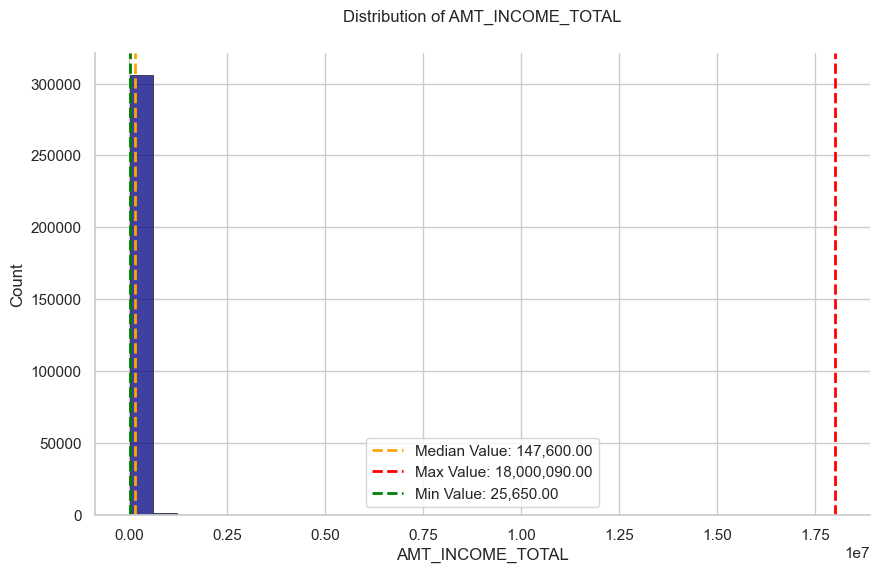

In [48]:
# Plot 'AMT_INCOME_TOTAL'
plot_num_dist(app_train_eda, 'AMT_INCOME_TOTAL')

The distribution of total borrower income exhibits a significant outlier, with a median value of 147,150 units. The distribution is right-skewed, indicating that most incomes are concentrated toward the lower end but with a few exceptionally high values. The maximum recorded income is 18.000.090 units, highlighting the presence of a substantial outlier (even after extreme outliers removed). On the other hand, the minimum total borrower income is reported at 25,650 units, indicating the range of income values in the dataset.

### Amount of Credit & Annuity Distribution

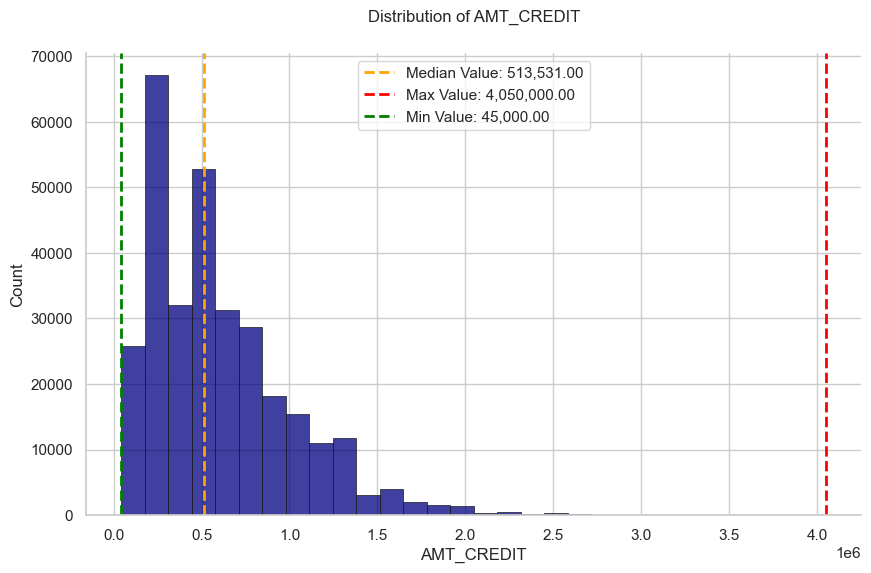

In [49]:
# Plot 'AMT_CREDIT'
plot_num_dist(app_train_eda, 'AMT_CREDIT')

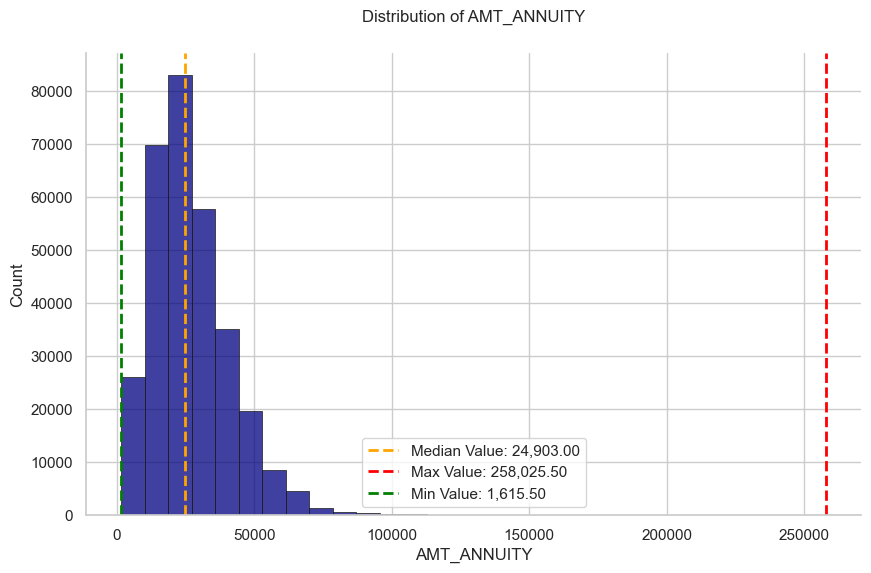

In [50]:
# Plot 'AMT_ANNUITY'
plot_num_dist(app_train_eda, 'AMT_ANNUITY')

The distribution of credit and annuity amounts appears to be right-skewed.

The median value of credit is 513,531 units, indicating that half of the observations fall below this value. However, the distribution is right-skewed, as the maximum value exceeds 4 million units, suggesting the presence of high outliers.

For annuities, the median value is 24,903 units, representing the middle value in the distribution. Similar to credit, the distribution of annuities is right-skewed, with the maximum value being 1,615 units.

These statistics highlight the concentration of values toward the lower end, with a few instances of significantly higher credit and annuity amounts.

### Income & Occupation Type

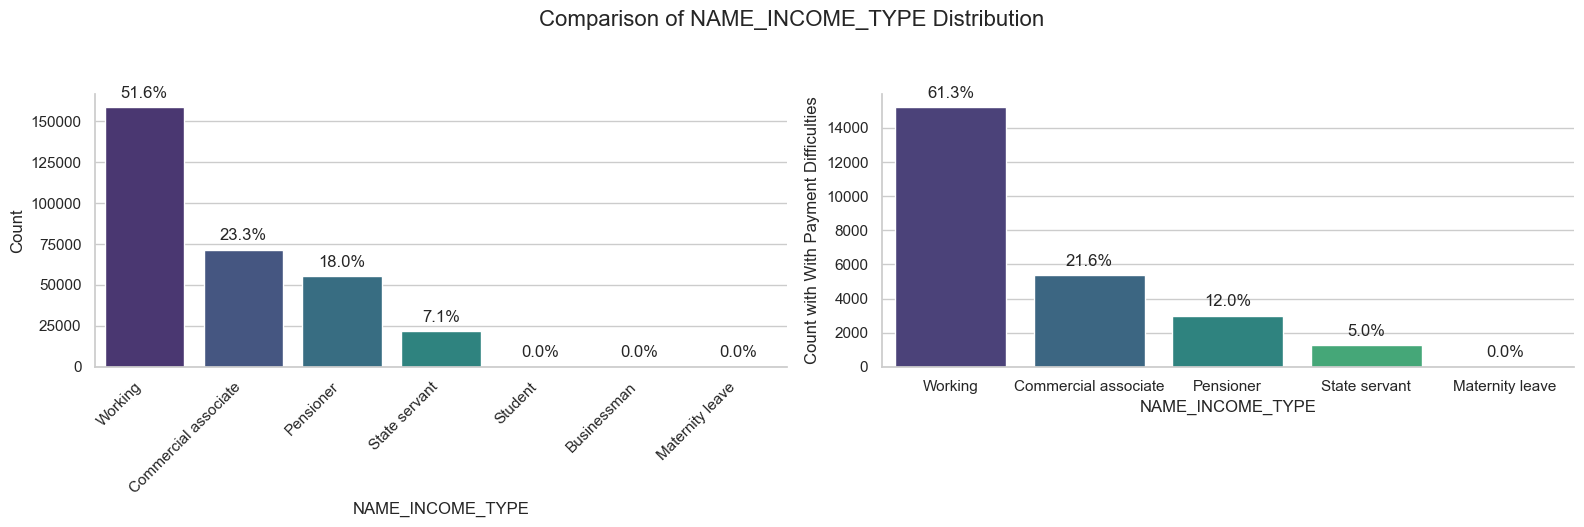

In [51]:
# Plot 'NAME_INCOME_TYPE'
plot_cat_dist(app_train_eda, 'NAME_INCOME_TYPE')

Borrowers with a working income type constitute the majority, making up 51.6% of the borrower population.

Despite being the most common income type, working individuals show a higher percentage of payment difficulties, indicating a relatively higher likelihood of encountering repayment challenges compared to borrowers with other income types.

Commercial associates, pensioners, and state servants contribute significantly to both the borrower population and cases with payment difficulties.

State servants, while representing the smallest portion, also contribute to cases with payment difficulties, albeit at a lower percentage.

Student, businessman, and maternity leave income type constitute very little (0%) of all data.

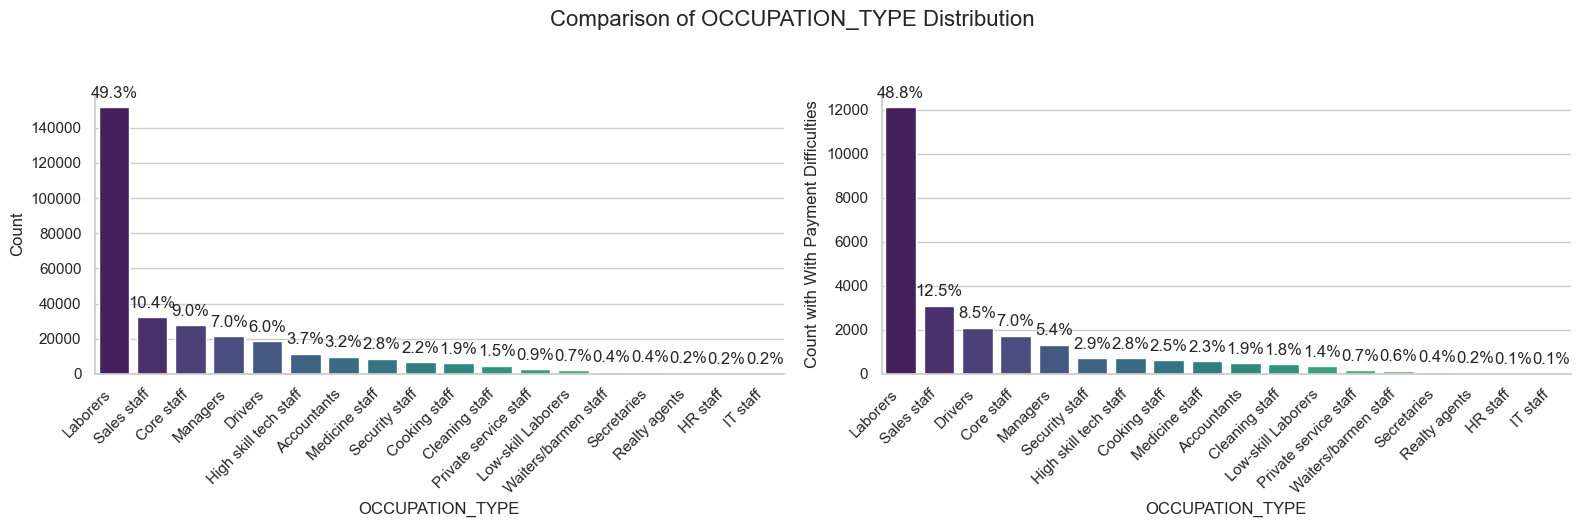

In [52]:
# Plot 'OCCUPATION_TYPE'
plot_cat_dist(app_train_eda, 'OCCUPATION_TYPE')

Laborers constitute the majority of borrowers, making up 49.3% of the borrower population.

Despite being the most common occupation type, laborers show a slightly lower percentage of payment difficulties, indicating a relatively lower likelihood of encountering repayment challenges compared to borrowers with other occupation types.

Sales staff, core staff, managers, and drivers contribute significantly to both the borrower population and cases with payment difficulties.

Drivers, while representing a smaller portion, exhibit a higher percentage in cases with payment difficulties, indicating a relatively higher likelihood of encountering repayment challenges compared to other occupation types.

### Education Level

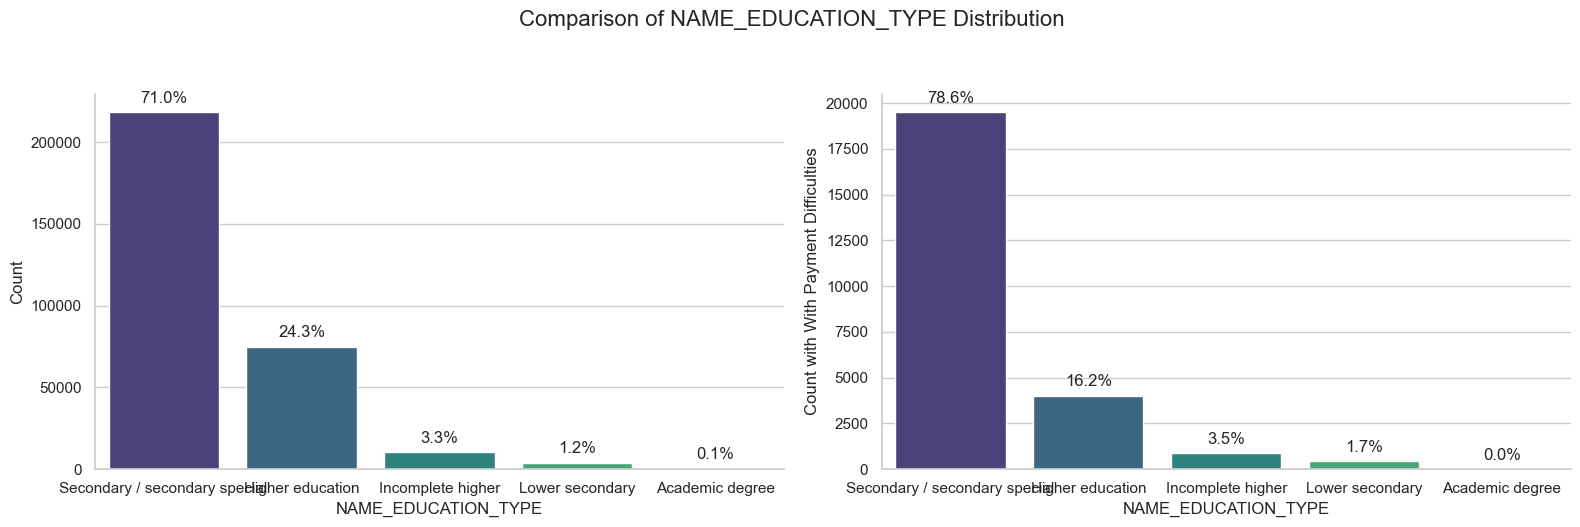

In [53]:
# Plot 'OCCUPATION_TYPE'
plot_cat_dist(app_train_eda, 'NAME_EDUCATION_TYPE')

Borrowers with a secondary or secondary special education level constitute the majority, making up 71% of the borrower population.

Despite being the most common education level, individuals with a secondary or secondary special education level show a higher percentage of payment difficulties, indicating a relatively higher likelihood of encountering repayment challenges compared to borrowers with other education levels.

Higher education, incomplete higher education, lower secondary education, and academic degree contribute significantly to both the borrower population and cases with payment difficulties.

While academic degree holders represent the smallest portion, they do not exhibit payment difficulties in the provided data.

### Work Address vs Contact Address vs Permanent Address

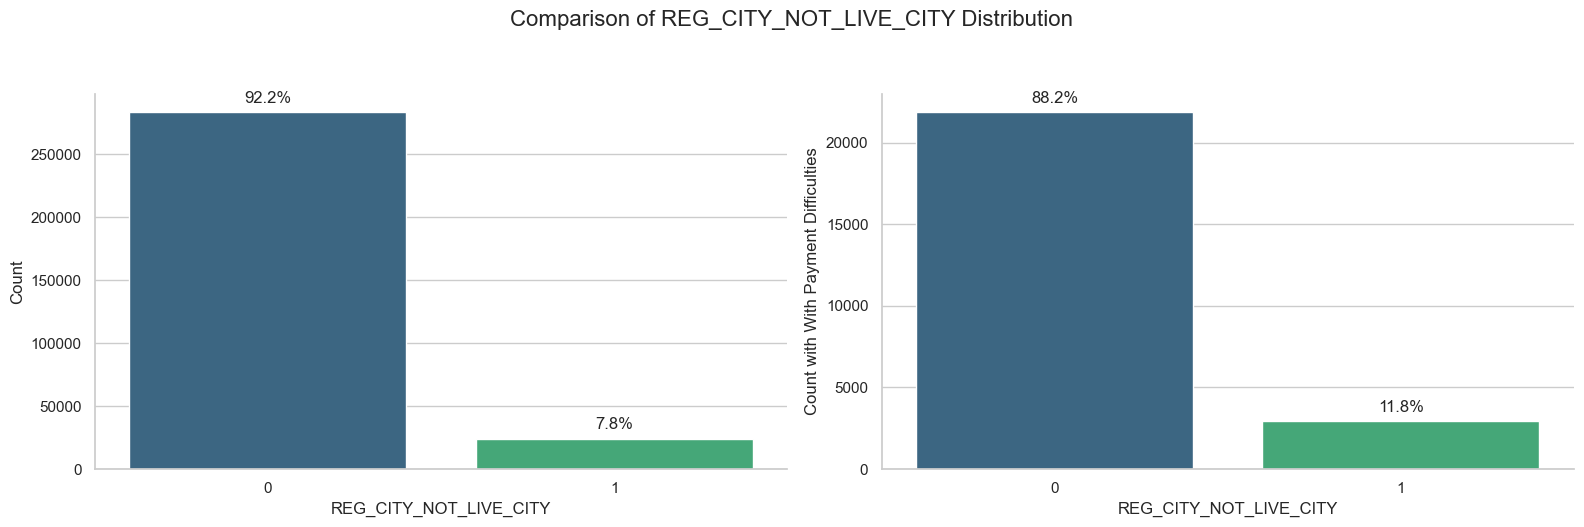

In [54]:
# Plot REG_CITY_NOT_LIVE_CITY
plot_cat_dist(app_train_eda, 'REG_CITY_NOT_LIVE_CITY')

In the overall dataset, the vast majority of borrowers (92%) have a permanent address that matches their contact address.

In cases with payment difficulties, there is a slight decrease in the percentage of borrowers (88.2%) whose permanent address matches their contact address, indicating a slightly higher likelihood of payment difficulties for those with non-matching addresses.

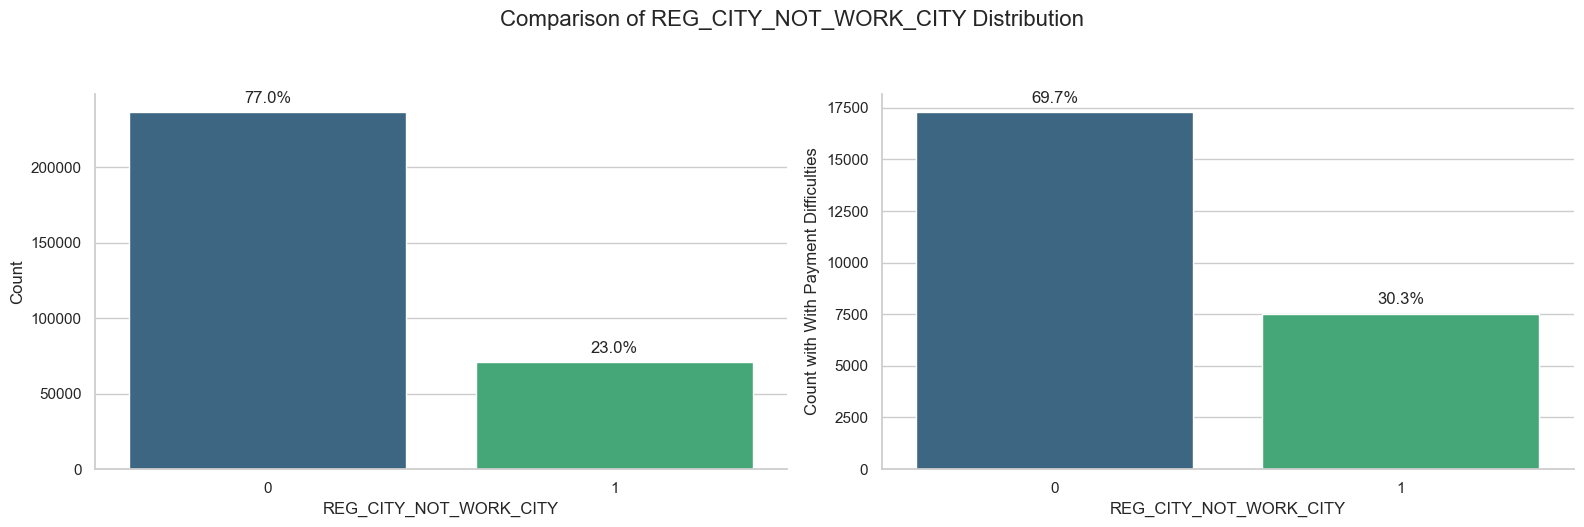

In [55]:
# Plot 'REG_CITY_NOT_WORK_CITY'
plot_cat_dist(app_train_eda, 'REG_CITY_NOT_WORK_CITY')

In the overall dataset, the majority of borrowers (77%) have a permanent address that matches their work address.

In cases with payment difficulties, there is a decrease in the percentage of borrowers (69.7%) whose permanent address matches their work address, indicating a higher likelihood of payment difficulties for those with non-matching addresses.

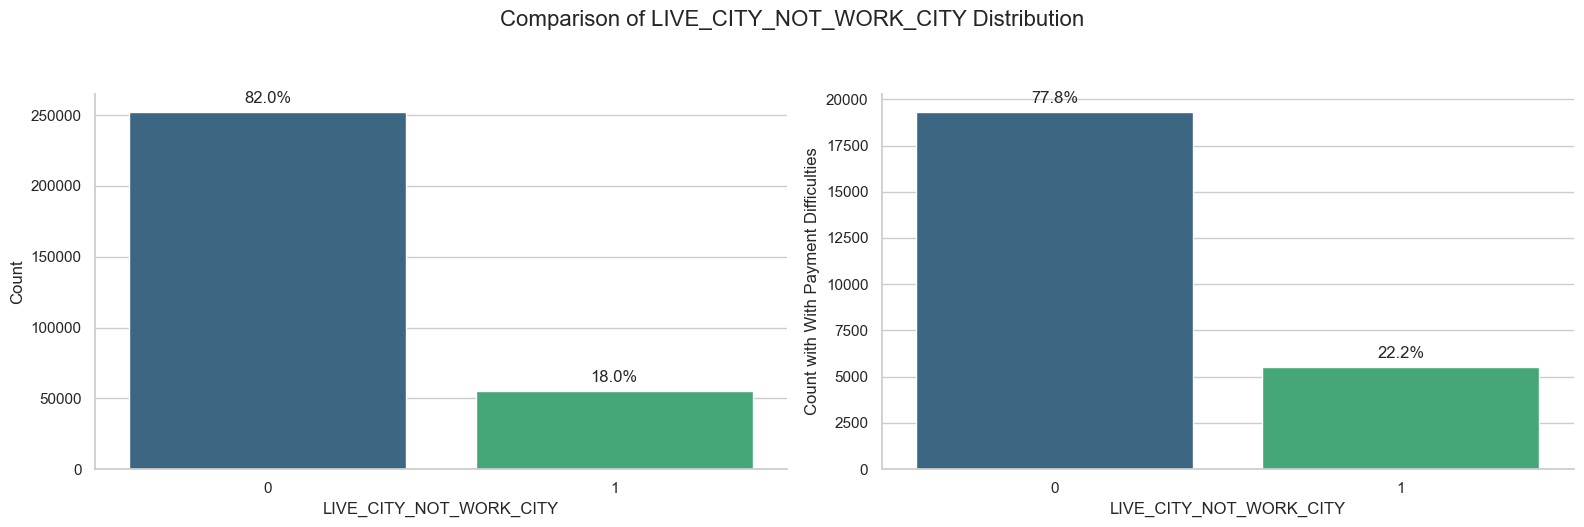

In [56]:
# Plot 'REG_CITY_NOT_WORK_CITY'
plot_cat_dist(app_train_eda, 'LIVE_CITY_NOT_WORK_CITY')

In the overall dataset, the majority of borrowers (82%) have a contact address that matches their work address.

In cases with payment difficulties, there is a decrease in the percentage of borrowers (77.8%) whose contact address matches their work address, indicating a higher likelihood of payment difficulties for those with non-matching addresses.

### Borrowers Age

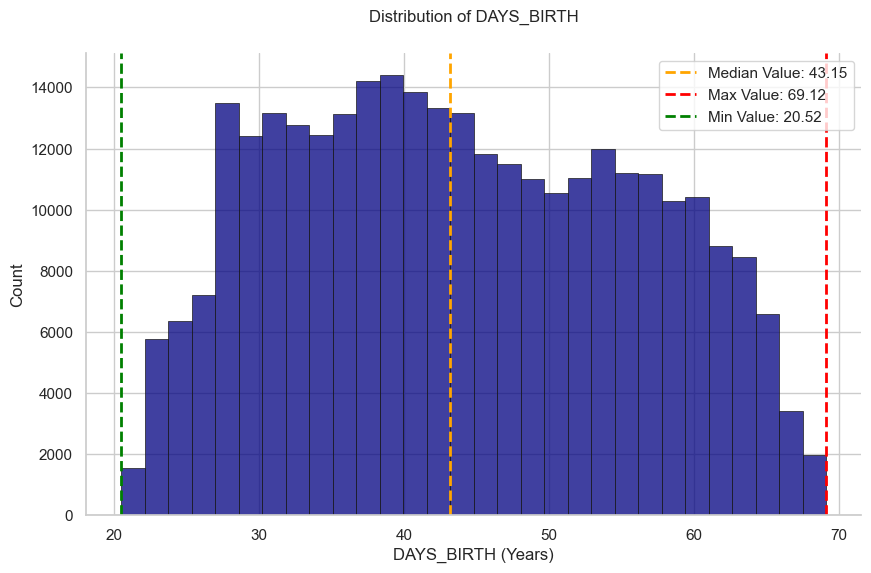

In [57]:
# Plot 'DAYS_BIRTH'
plot_num_dist(app_train_eda, 'DAYS_BIRTH', duration= 'year')

It can bee seen that borrower age follows a normal distribution, ranging from 20 to 60 years, with no outlier values. The average age of borrowers is 44 years.

To enhance the visibility of patterns, I will categorize ages into four distinct groups.

In [58]:
# Grouping age into 4 broad categories
age_data= app_train_eda[['DAYS_BIRTH', 'TARGET']]
age_data['AGE']= age_data['DAYS_BIRTH'] / 365

age_group= []

for age in age_data['AGE']:
    if age <= 30:
        group = 'Young Adult'
    elif age <= 45:
        group = 'Adult'
    elif age <= 60:
        group = 'Middle Age'
    else:
        group = 'Young Old'
    age_group.append(group)

age_data['AGE_GROUP']= age_group

age_data.head()

,DAYS_BIRTH,TARGET,AGE,AGE_GROUP
0,9461,With Payment Difficulties,25.920548,Young Adult
1,16765,Without Payment Difficulties,45.931507,Middle Age
2,19046,Without Payment Difficulties,52.180822,Middle Age
3,19005,Without Payment Difficulties,52.068493,Middle Age
4,19932,Without Payment Difficulties,54.608219,Middle Age


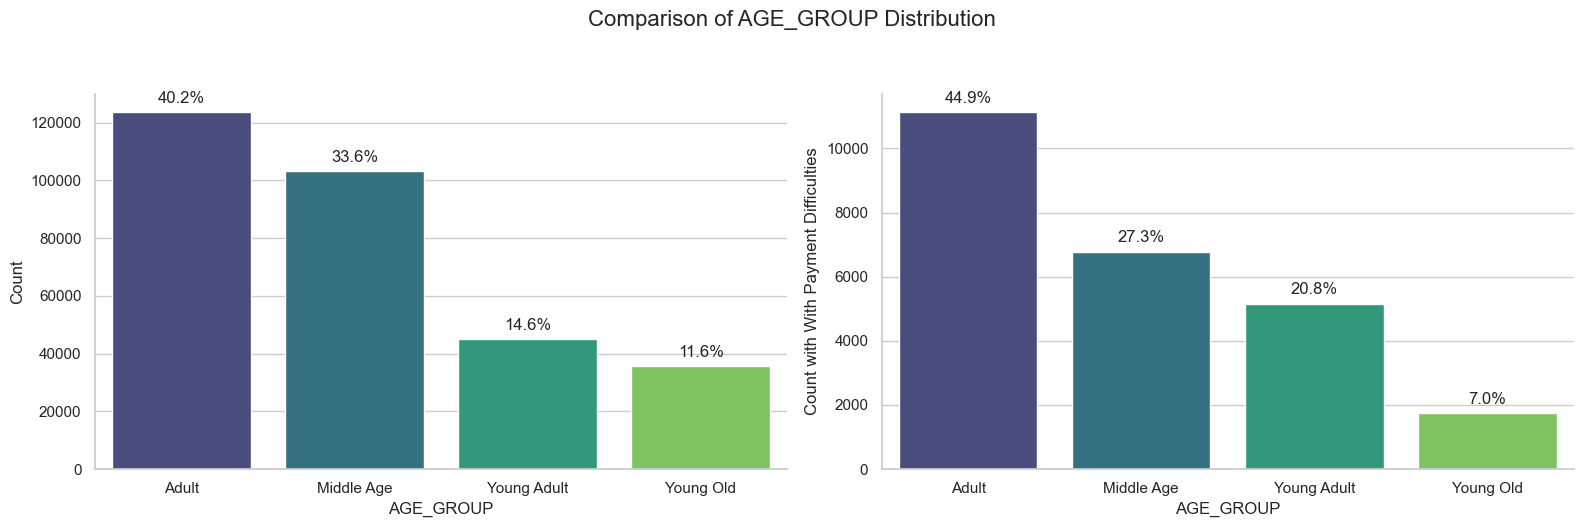

In [59]:
# Plot 'AGE_GROUP'
plot_cat_dist(age_data, 'AGE_GROUP')

Adults aged 31 to 45 years constitute the largest age group among borrowers, making up 40.2% of the borrower population.

Despite being the most common age group, adults aged 31 to 45 years show a higher percentage of payment difficulties, indicating a relatively higher likelihood of encountering repayment challenges compared to borrowers in other age groups.

Middle-aged individuals (46 - 60 years old) and young adults (below 30 years old) contribute significantly to both the borrower population and cases with payment difficulties.

Young old individuals (above 60 years old), while representing a smaller portion, exhibit a lower percentage in cases with payment difficulties, indicating a relatively lower likelihood of encountering repayment challenges compared to other age groups.

### Employment Duration

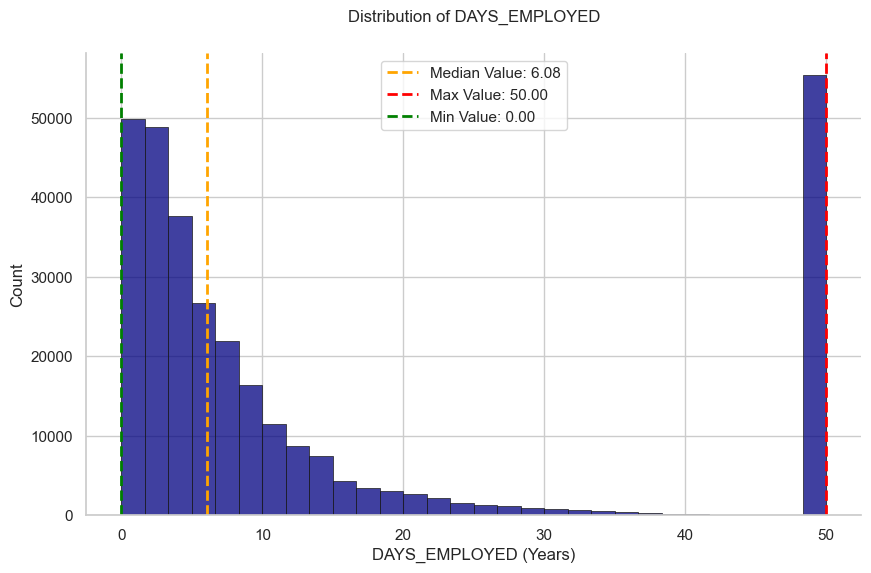

In [60]:
# Plot 'DAYS_EMPLOYED'
plot_num_dist(app_train_eda, 'DAYS_EMPLOYED', duration= 'year')

The median duration of employment for borrowers when taking out a loan is 5 years, indicating that half of the borrowers have an employment duration of 6 years or less. Notably, the dataset includes a maximum employment duration of 50 years, suggesting the presence of borrowers with extensive work histories.

### Organization Type

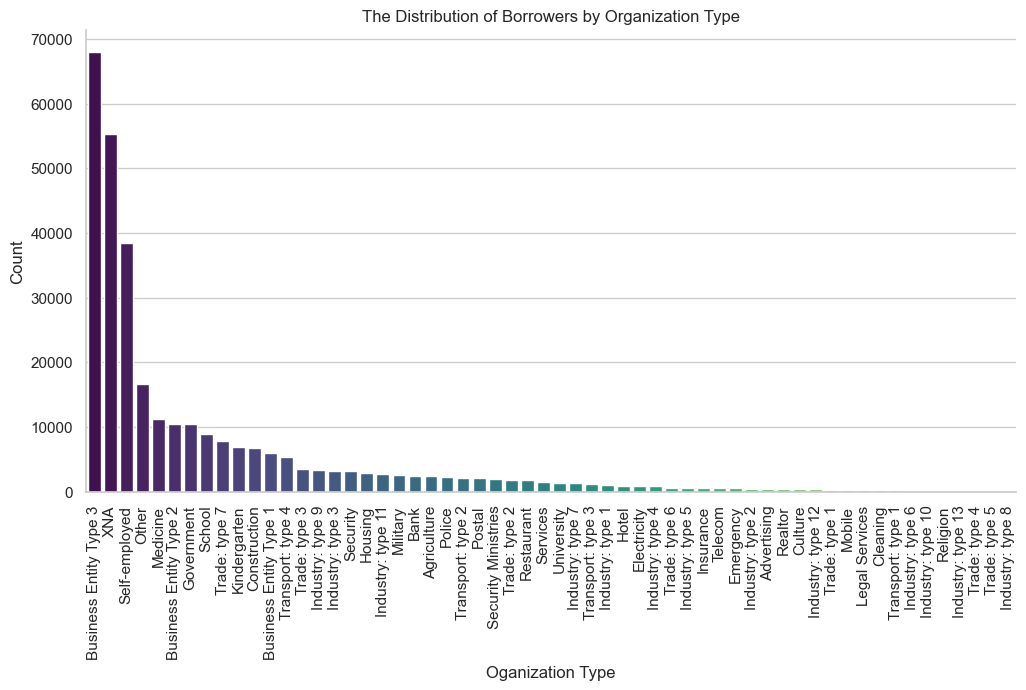

In [61]:
# Plot 'ORGANIZATION_TYPE'
organization_type_count= app_train_eda['ORGANIZATION_TYPE'].value_counts()
order_ot= organization_type_count.index

plt.figure(figsize= (12, 6))
sns.countplot(data= app_train_eda, x= 'ORGANIZATION_TYPE', palette= 'viridis', order= order_ot)
plt.xticks(rotation= 90)
plt.title("The Distribution of Borrowers by Organization Type")
plt.xlabel('Oganization Type')
plt.ylabel('Count')

sns.despine()
plt.show()

In [62]:
app_train['ORGANIZATION_TYPE'].nunique()

58

With a total of 58 unique values, it is evident that borrowers represent various types of organizations. Notably, the organization type labeled as Business Entity Type 3 has the highest frequency among borrowers. The second-highest frequency is associated with the XNA organization type, suggesting that some borrowers might not have provided information about their organization type during the data input process. On the other hand, the lowest frequency is observed for Industry: Type 8. This information highlights the diversity in borrowers' organizational affiliations, with some instances of missing or unspecified data in the organization type field.

### Region Rating

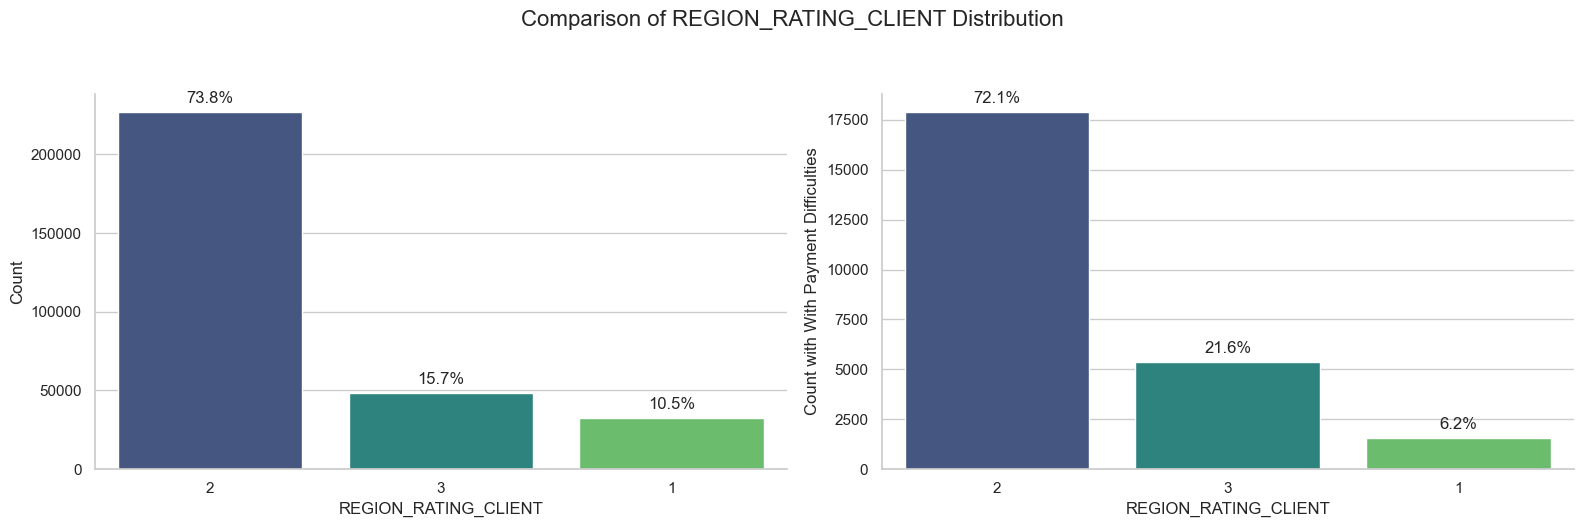

In [63]:
#  Plot 'REGION_RATING_CLIENT'
plot_cat_dist(app_train_eda, 'REGION_RATING_CLIENT')

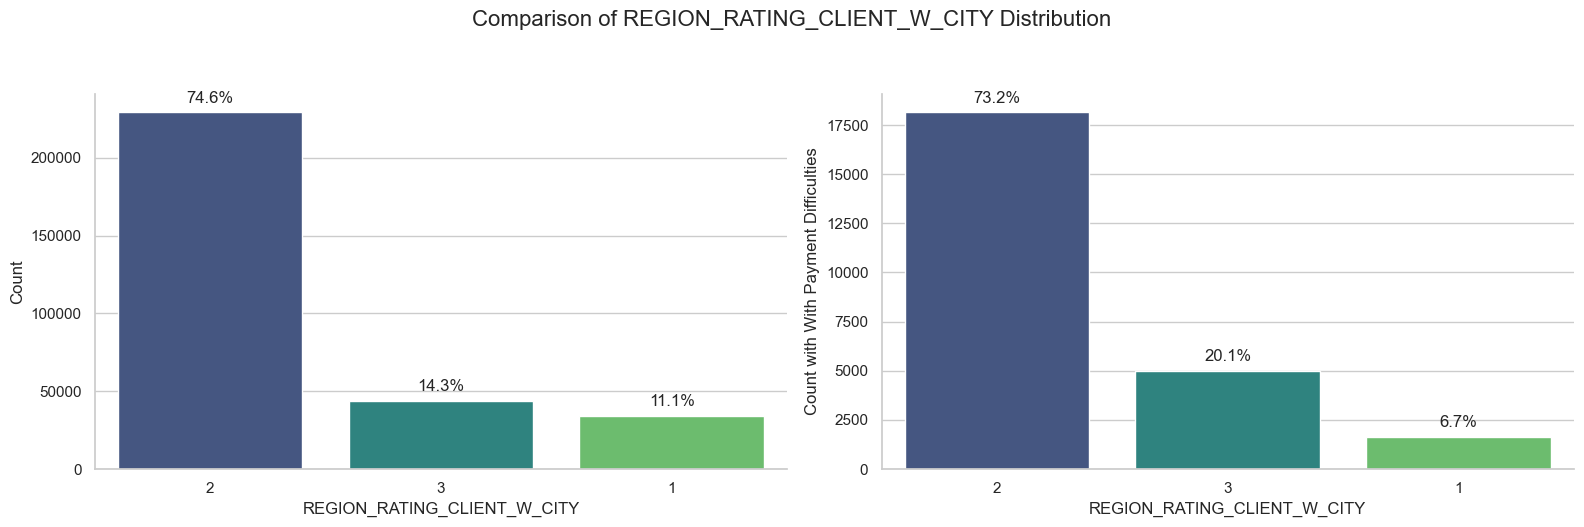

In [64]:
#  Plot 'REGION_RATING_CLIENT_W_CITY'
plot_cat_dist(app_train_eda, 'REGION_RATING_CLIENT_W_CITY')

Borrowers with a region rating of 2 constitute the majority, making up 73.8% of the borrower population.

Despite being the most common region rating, individuals with a region rating of 2 show a slightly lower percentage of payment difficulties, indicating a relatively lower likelihood of encountering repayment challenges compared to borrowers with other region ratings.

Region ratings 3 and 1 contribute significantly to both the borrower population and cases with payment difficulties.
While region rating 1 represents the smallest portion, it exhibits a lower percentage in cases with payment difficulties, indicating a relatively lower likelihood of encountering repayment challenges compared to other region ratings.

### Housing Information

The provided dataset includes housing or residence information for borrowers, represented by normalized values in three columns each: _MEDI, _MODE, and _AVG. We will analyze the correlation between these columns.

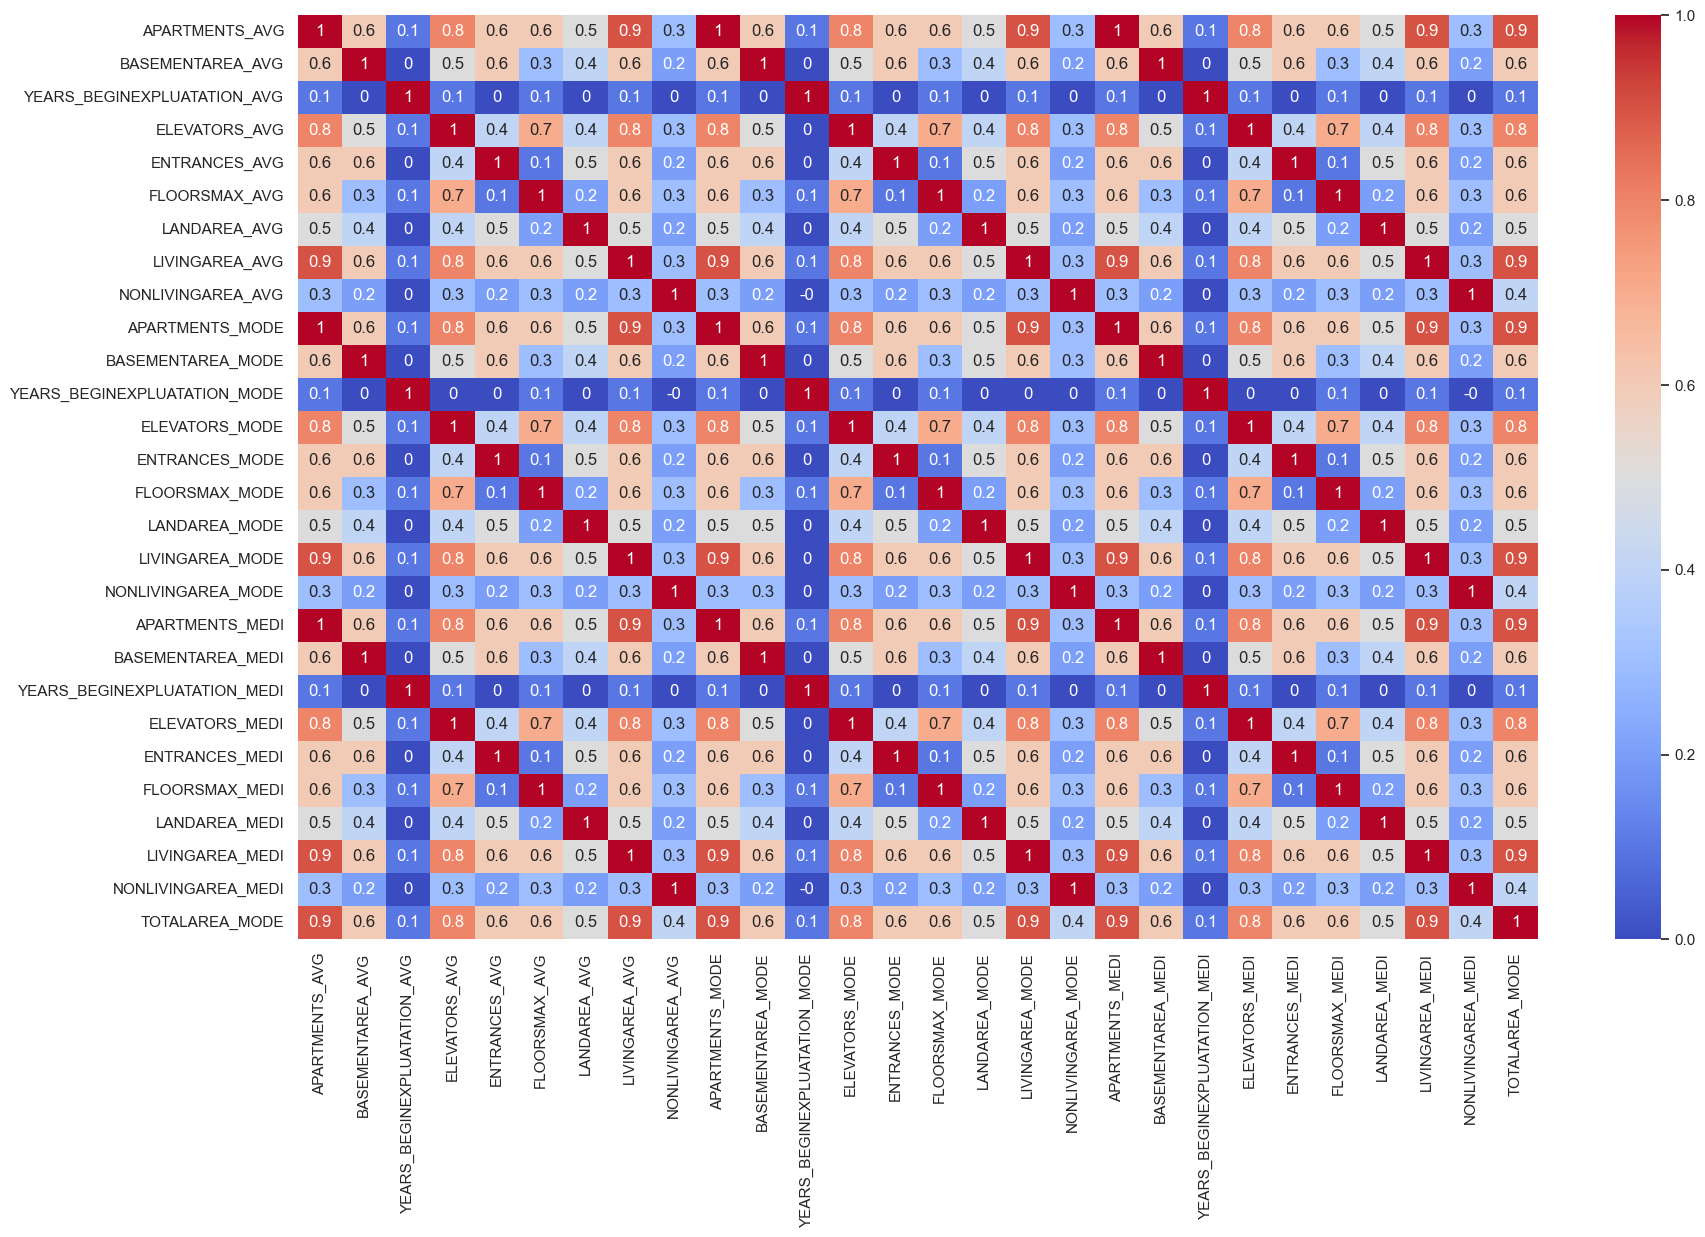

In [65]:
housing_cols = [col for col in app_train_eda.columns if any(suffix in col for suffix in ['_MEDI', '_MODE', '_AVG'])]

plt.figure(figsize= (20, 12))
sns.heatmap(round(app_train_eda[housing_cols].corr(), 1), annot= True, cmap= 'coolwarm')

plt.show()

The information columns exhibit high correlation among those with different suffixes, indicating redundancy. Retaining one column with a specific suffix is sufficient to represent the information, leading to the proposal of removing the other two suffixes. This simplification aids in reducing column dimensions.

#  Data Preprocessing

In [66]:
app_train.sample(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
117054,235733,0,Cash loans,F,N,Y,0,162000.0,1125000.0,33025.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,5.0
226275,362085,0,Cash loans,M,N,Y,1,315000.0,450000.0,47254.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
198102,329681,0,Cash loans,F,N,Y,0,207000.0,463941.0,17320.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [67]:
app_train_feat= app_train.copy()
app_test_feat= app_test.copy()

In [68]:
#app_train_feat= pd.read_csv('app_train_clean.csv')
#app_test_feat= pd.read_csv('app_test_clean.csv')

Following up on findings regarding the correlation of columns related to housing information, I will first delete the redundant columns.

In [69]:
check_column_type(app_train_feat)

,Column,Data Type,Is Categorical,Is Numerical,Range/Unique Values
0,SK_ID_CURR,int64,False,True,"(100002, 456255)"
1,TARGET,int64,False,True,"(0, 1)"
2,NAME_CONTRACT_TYPE,object,True,False,2
3,CODE_GENDER,object,True,False,3
4,FLAG_OWN_CAR,object,True,False,2
5,FLAG_OWN_REALTY,object,True,False,2
6,CNT_CHILDREN,int64,False,True,"(0, 19)"
7,AMT_INCOME_TOTAL,float64,False,True,"(25650.0, 18000090.0)"
8,AMT_CREDIT,float64,False,True,"(45000.0, 4050000.0)"
9,AMT_ANNUITY,float64,False,True,"(1615.5, 258025.5)"


I will delete the columns with the suffixes _MEDI and _MODE, and keep the columns with the suffix _AVG. However, certain columns with the suffix _MODE, which contain categorical values without related columns with other suffixes, will be retained.

In [70]:
# Filter columns to drop
exclude_cols = ['HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
housing_cols = [col for col in app_train_eda.columns if any(suffix in col for suffix in ['_MEDI', '_MODE']) and col not in exclude_cols]

app_train_feat.drop(housing_cols, axis= 1, inplace= True)
app_test_feat.drop(housing_cols, axis= 1, inplace= True)

## Feature Extraction

In this phase, I will derive new features from existing ones, intending to either substitute certain old features with the new ones or eliminate redundant features that are adequately represented by the newly created ones.

#### AGE

In [71]:
# Borrower age at the time of application
app_train_feat['AGE'] = app_train_feat['DAYS_BIRTH'] / 365

In [72]:
# Drop 'DAYS_BIRTH'
app_train_feat.drop(['DAYS_BIRTH'], axis= 1, inplace= True)

#### EMPLOYMENT_DURATION

In [73]:
# Borrower employment duration
app_train_feat['EMPLOYMENT_DURATION'] = app_train_feat['DAYS_EMPLOYED'] /365

In [74]:
# Drop 'DAYS_BIRTH'
app_train_feat.drop(['DAYS_EMPLOYED'], axis= 1, inplace= True)

#### CREDIT_INCOME_RATIO

In [75]:
# Proportion of income covered by the credit amount
app_train_feat['CREDIT_INCOME_RATIO'] = app_train_feat['AMT_CREDIT'] / app_train_feat['AMT_INCOME_TOTAL']

#### ANNUITY_INCOME_RATIO


In [76]:
# Proportion of income covered by the annuity amount
app_train_feat['ANNUITY_INCOME_RATIO'] = app_train_feat['AMT_CREDIT'] / app_train_feat['AMT_ANNUITY']

#### CREDIT_ANNUITY_RATIO

In [77]:
# Credit to annuity ratio/ can also be interpreted as loan term
app_train_feat['CREDIT_ANNUITY_RATIO'] = app_train_feat['AMT_CREDIT']/app_train_feat['AMT_ANNUITY']

#### INCOME_PER_DEPENDENT

In [78]:
# Calculate the ratio of income to the number of dependents (including the applicant)
app_train_feat['INCOME_PER_DEPENDENT'] = app_train_feat['AMT_INCOME_TOTAL'] / (app_train_feat['CNT_CHILDREN'] + 1)

#### CREDIT_GOOD_PRICE_RATIO

In [79]:
# Calculate the ratio of the amount of credit to the price of goods
app_train_feat['CREDIT_GOOD_PRICE_RATIO'] = app_train_feat['AMT_CREDIT'] / app_train_feat['AMT_GOODS_PRICE']

#### EMPLOYMENT_AGE_RATIO

In [80]:
# Calculate the ratio of days employed to days of birth
app_train_feat['EMPLOYMENT_AGE_RATIO'] = app_train_feat['EMPLOYMENT_DURATION'] / app_train_feat['AGE']

#### EXTERNAL_SOURCE_AVG

In [81]:
# Consolidated external source score
app_train_feat['EXTERNAL_SOURCE_AVG'] = (app_train_feat[['EXT_SOURCE_1', 'EXT_SOURCE_2','EXT_SOURCE_3']].sum(axis= 1))/3

#### CONTACT_INFO_MISMATCH

In [82]:
# Create a new column 'CONTACT INFO MISMATCH'
app_train_feat['CONTACT_INFO_MISMATCH'] = app_train_feat[
    ['REG_REGION_NOT_LIVE_REGION', 'REG_CITY_NOT_WORK_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY']
].sum(axis=1)

# If the value in the 'CONTACT INFO MISMATCH' column is more than 0, it means there is a contact information mismatch
app_train_feat['CONTACT_INFO_MISMATCH'] = (app_train_feat['CONTACT_INFO_MISMATCH'] > 0).astype(int)

#### SOCIAL_SURROUNDING

In [83]:
# Get a total count of observations in the client's social surroundings
app_train_feat['SOCIAL_SURROUNDING'] = app_train_feat[['OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE' ]].sum(axis= 1)

In [84]:
# Drop 'OBS_30_CNT_SOCIAL_CIRCLE' and 'OBS_60_CNT_SOCIAL_CIRCLE'
app_train_feat.drop(['OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE'], axis= 1, inplace= True)

#### SOCIAL_SURROUNDING_DEF

In [85]:
# Get a total count of observations in the client's social surroundings that defaulted on a loan
app_train_feat['SOCIAL_SURROUNDING_DEF'] = app_train_feat[['DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE' ]].sum(axis= 1)

In [86]:
# Drop 'DEF_30_CNT_SOCIAL_CIRCLE' and 'DEF_60_CNT_SOCIAL_CIRCLE'
app_train_feat.drop(['DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'], axis= 1, inplace= True)

#### SUM_DOC

This column contains the sum of the column values related to the document. It can also be interpreted as the number of documents submitted by the borrower.

In [87]:
# Get columns that contain 'DOCUMENT' in their name
document_columns = app_train_feat.filter(like='FLAG_DOCUMENT').columns

app_train_feat['SUM_DOCUMENT'] = app_train_feat[document_columns].sum(axis=1)

In [88]:
# Drop document related columns
doc_cols= ['FLAG_DOCUMENT_1', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
           'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
           'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

# Check if columns exist before dropping
columns_to_drop = [col for col in doc_cols if col in app_train_feat.columns]
app_train_feat.drop(columns=columns_to_drop, axis=1, inplace=True)

In [89]:
# Test data treatment

# Calculate AGE
app_test_feat['AGE'] = app_test_feat['DAYS_BIRTH'] / 365
app_test_feat.drop(['DAYS_BIRTH'], axis=1, inplace=True)

# Calculate EMPLOYMENT_DURATION
app_test_feat['EMPLOYMENT_DURATION'] = app_test_feat['DAYS_EMPLOYED'] / 365
app_test_feat.drop(['DAYS_EMPLOYED'], axis=1, inplace=True)

# Calculate Ratios
app_test_feat['CREDIT_INCOME_RATIO'] = app_test_feat['AMT_CREDIT'] / app_test_feat['AMT_INCOME_TOTAL']
app_test_feat['ANNUITY_INCOME_RATIO'] = app_test_feat['AMT_CREDIT'] / app_test_feat['AMT_ANNUITY']
app_test_feat['CREDIT_ANNUITY_RATIO'] = app_test_feat['AMT_CREDIT'] / app_test_feat['AMT_ANNUITY']
app_test_feat['INCOME_PER_DEPENDENT'] = app_test_feat['AMT_INCOME_TOTAL'] / (app_test_feat['CNT_CHILDREN'] + 1)
app_test_feat['CREDIT_GOOD_PRICE_RATIO'] = app_test_feat['AMT_CREDIT'] / app_test_feat['AMT_GOODS_PRICE']
app_test_feat['EMPLOYMENT_AGE_RATIO'] = app_test_feat['AGE'] / app_test_feat['EMPLOYMENT_DURATION']

# Calculate EXTERNAL_SOURCE_AVG
app_test_feat['EXTERNAL_SOURCE_AVG'] = app_test_feat[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

# Calculate CONTACT_INFO_MISMATCH
contact_info_flags = ['REG_REGION_NOT_LIVE_REGION', 'REG_CITY_NOT_WORK_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY']
app_test_feat['CONTACT_INFO_MISMATCH'] = (app_test_feat[contact_info_flags].sum(axis=1) > 0).astype(int)

# Calculate SOCIAL_SURROUNDING
app_test_feat['SOCIAL_SURROUNDING'] = app_test_feat[['OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE']].sum(axis=1)
app_test_feat.drop(['OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE'], axis=1, inplace=True)

app_test_feat['SOCIAL_SURROUNDING_DEF'] = app_test_feat[['DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']].sum(axis=1)
app_test_feat.drop(['DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'], axis=1, inplace=True)

# Preprocess Documents
document_columns = app_test_feat.filter(like='FLAG_DOCUMENT').columns
app_test_feat['SUM_DOCUMENT'] = app_test_feat[document_columns].sum(axis=1)
columns_to_drop = [col for col in document_columns if col in app_test_feat.columns]
app_test_feat.drop(columns=columns_to_drop, axis=1, inplace=True)

In [90]:
print("Train data shape after feature extraction: ", app_train_feat.shape)
print("Test data shape after feature extraction: ", app_test_feat.shape)

Train data shape after feature extraction:  (307488, 74)
Test data shape after feature extraction:  (41138, 73)


## Feature Encoding

I use two types of encoding techniques, namely label encoding and one-hot encoding. Label encoding is applied to categorical columns with only two unique values, effectively converting them into numerical representations. On the other hand, one-hot encoding is used for columns with more than two unique categorical values. This technique expands the categorical columns into a binary matrix, creating separate binary columns for each category.

In [91]:
categorical_columns = app_train_feat.select_dtypes(include='object').columns

# Get categorical columns with less than 3 unique values for Label Encoding
col_to_label = [col for col in categorical_columns if app_train_feat[col].nunique() < 3]

# Get categorical columns with a total of 3 or more unique values for One-Hot Encoding
col_to_ohe = [col for col in categorical_columns if col not in col_to_label]


label_encoder = LabelEncoder()

# Label encoding
for col in col_to_label:
    app_train_feat[col] = label_encoder.fit_transform(app_train_feat[col])

# Ohe encoding
app_train_feat = pd.get_dummies(app_train_feat, columns=col_to_ohe)

In [92]:
# Test data treatment

for col in col_to_label:
    app_test_feat[col] = label_encoder.fit_transform(app_test_feat[col])

app_test_feat = pd.get_dummies(app_test_feat, columns=col_to_ohe)

In [93]:
print("Train data shape after feature encoding process: ", app_train_feat.shape)
print("Test data shape after feature encoding process: ", app_test_feat.shape)

Train data shape after feature encoding process:  (307488, 190)
Test data shape after feature encoding process:  (41138, 186)


## Aligning Train & Test Data

To ensure consistent features in both training and testing datasets, we align the dataframes. Due to one-hot encoding, the training data may have additional columns with categories not found in the testing data. Extraction of the target column from the training data is performed before alignment to retain essential information. Setting axis = 1 ensures alignment based on columns, eliminating training data columns absent in the testing data.

In [94]:
# Align train & test data
labels = app_train_feat['TARGET']

train, test = app_train_feat.align(app_test_feat, join='inner',axis=1)

train['TARGET'] = labels

In [95]:
print("Train data shape after alignment: ", train.shape)
print("Test data shape after alignment: ", test.shape)

Train data shape after alignment:  (307488, 187)
Test data shape after alignment:  (41138, 186)


## Feature Scaling

Scaling functions help machine learning models to more effectively handle features of different scales, speed up convergence in learning algorithms, and ensure better interpretability in some types of models.

In [96]:
# Get the list of all columns in the DataFrame
columns = train.columns.to_list()

# Remove 'SK_ID_CURR' and 'TARGET' from the list
columns.remove('SK_ID_CURR')
columns.remove('TARGET')

# Identify columns with numeric values that have a range greater than 1
col_to_scale = [col for col in columns if train[col].max() > 1]

# Create a MinMaxScaler object
scaler = StandardScaler()

# Apply Min-Max Scaling to the identified columns
train[col_to_scale] = scaler.fit_transform(train[col_to_scale])

In [97]:
# Test data treatment
test[col_to_scale] = scaler.fit_transform(test[col_to_scale])

## Feature Selection

At this stage, I will assess feature importance using a correlation matrix between features and targets because features with a high correlation to the target tend to be more relevant. Afterward, I will select the top 30 most relevant features for inclusion in the modeling process. Additionally, I will examine the correlation among these selected features and eliminate those with high correlation values to mitigate multicollinearity.

Multicollinearity refers to a statistical phenomenon in which two or more independent variables in a regression model are highly correlated. In other words, it occurs when there is a strong linear relationship between two or more predictor variables, making it challenging to isolate the individual effect of each variable on the dependent variable. This phenomenon can have several implications for regression analysis.

Please refer to this [article](https://www.investopedia.com/terms/m/multicollinearity.asp#:~:text=Multicollinearity%20is%20a%20statistical%20concept,in%20less%20reliable%20statistical%20inferences.) for further reading about multicollinearity.

In [98]:
correlation_matrix = train.corr()
target_correlation = correlation_matrix['TARGET'].abs().sort_values(ascending=False)
selected_features = target_correlation.head(30).index.tolist()

# Convert selected_features to DataFrame
selected_features_df = pd.DataFrame({'Feature': selected_features})

# Add correlation values to the DataFrame
selected_features_df['Correlation_with_TARGET'] = selected_features_df['Feature'].apply(lambda x: correlation_matrix.loc[x, 'TARGET'])

# Display the DataFrame
print(selected_features_df)

                                              Feature  Correlation_with_TARGET
0                                              TARGET                 1.000000
1                                 EXTERNAL_SOURCE_AVG                -0.220786
2                                        EXT_SOURCE_2                -0.160212
3                                        EXT_SOURCE_3                -0.155908
4                                        EXT_SOURCE_1                -0.098852
5                                                 AGE                -0.078271
6                             CREDIT_GOOD_PRICE_RATIO                 0.068551
7                                 EMPLOYMENT_DURATION                -0.066596
8                                EMPLOYMENT_AGE_RATIO                -0.065229
9                         REGION_RATING_CLIENT_W_CITY                 0.060911
10                               REGION_RATING_CLIENT                 0.058924
11                           NAME_INCOME_TYPE_Workin

In [99]:
# Filter top most relevant features (excluding 'TARGET')
top_features = selected_features_df[selected_features_df['Feature'] != 'TARGET']['Feature'].tolist()

train_selected = train[top_features]
train_selected['TARGET'] = train['TARGET']
test_selected = test[top_features]

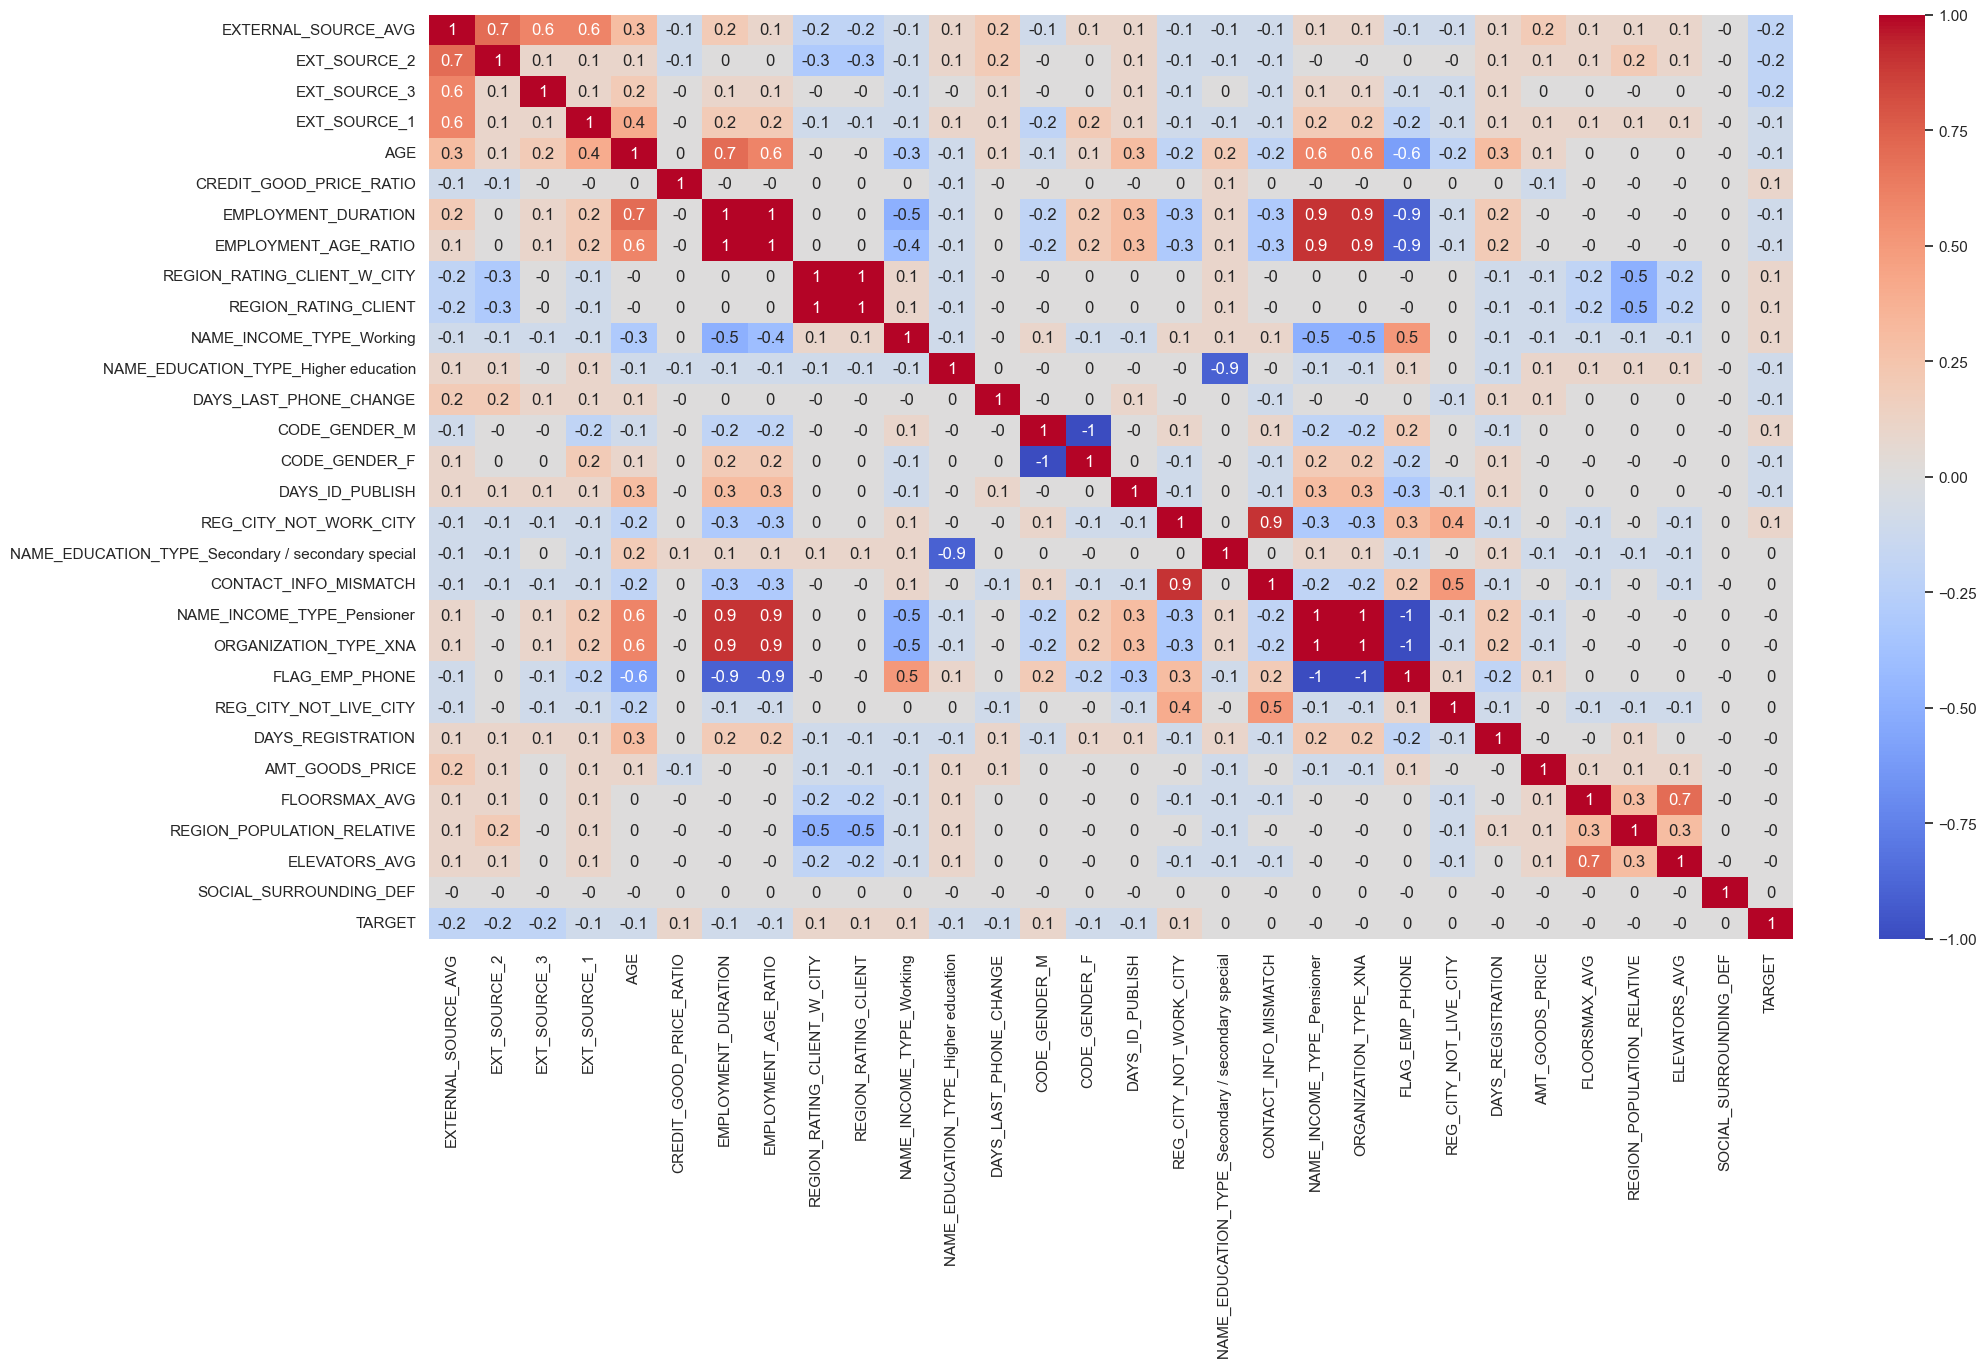

In [100]:
# Display features correlation
plt.figure(figsize= (22, 12))
sns.heatmap(round(train_selected.corr(), 1), annot= True, cmap= 'coolwarm')

plt.show()

It is evident that several features exhibit high correlation with others. The choice of threshold for assessing the presence of multicollinearity may vary, but for this analysis, a threshold of 0.8 has been adopted, as indicated in this  [document](https://www.sfu.ca/~dsignori/buec333/lecture%2016.pdfsource). Consequently, features exhibiting a correlation exceeding 0.8 will be removed from consideration.







In [101]:
# Drop highly correlated features
train_selected.drop(['EMPLOYMENT_AGE_RATIO', 'FLAG_EMP_PHONE', 'REGION_RATING_CLIENT', 'NAME_EDUCATION_TYPE_Higher education',
                     'ORGANIZATION_TYPE_XNA', 'NAME_INCOME_TYPE_Pensioner', 'REG_CITY_NOT_WORK_CITY'], axis= 1, inplace= True)
test_selected.drop(['EMPLOYMENT_AGE_RATIO', 'FLAG_EMP_PHONE', 'REGION_RATING_CLIENT', 'NAME_EDUCATION_TYPE_Higher education',
                     'ORGANIZATION_TYPE_XNA', 'NAME_INCOME_TYPE_Pensioner', 'REG_CITY_NOT_WORK_CITY'], axis= 1, inplace= True)

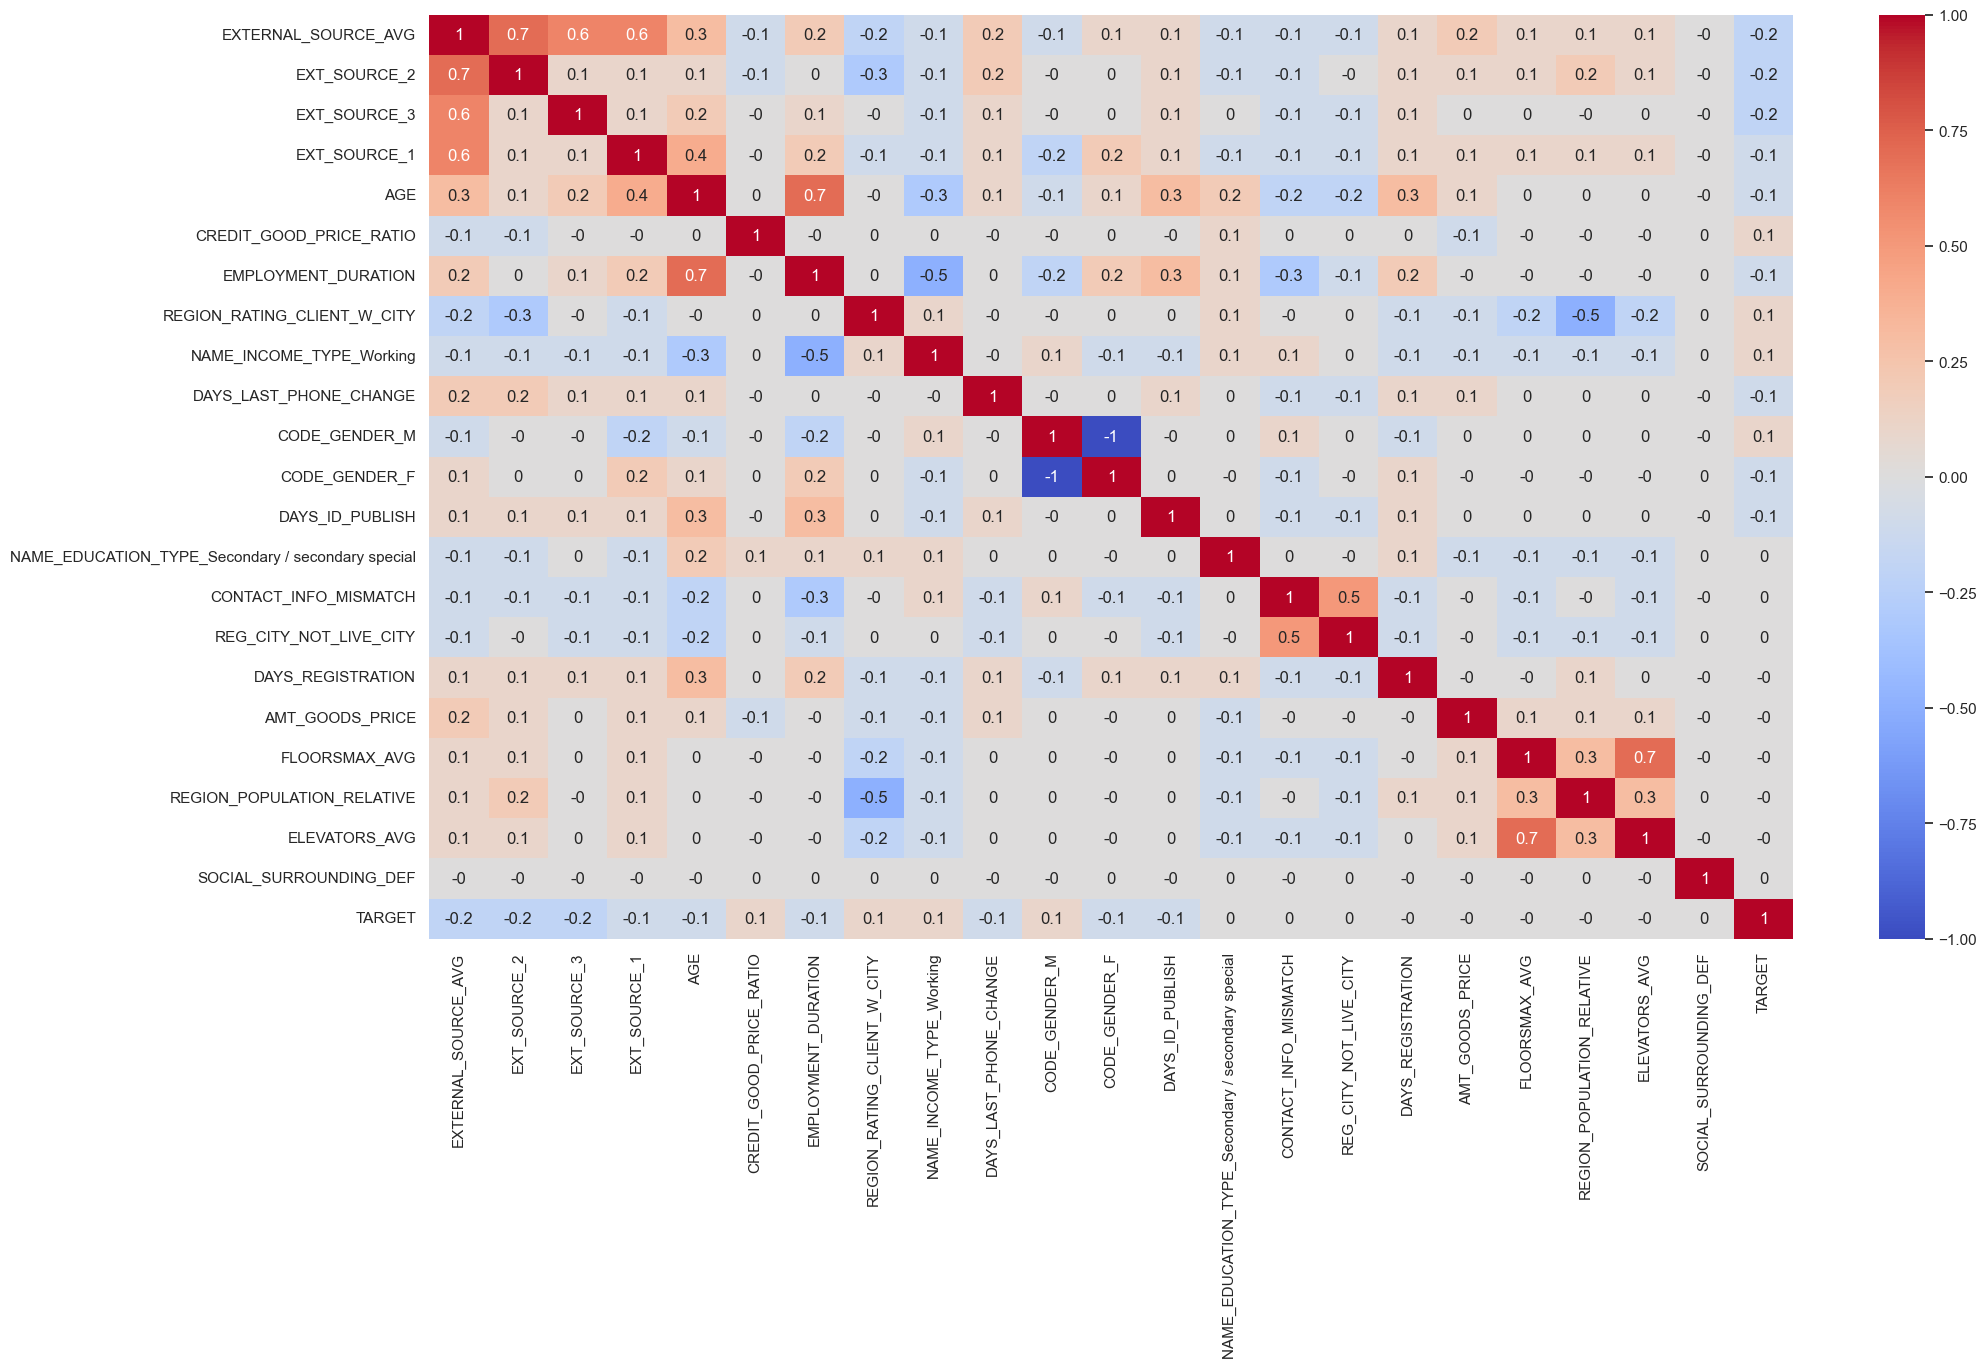

In [102]:
# Display features correlation
plt.figure(figsize= (22, 12))
sns.heatmap(round(train_selected.corr(), 1), annot= True, cmap= 'coolwarm')

plt.show()

In [103]:
print("Train data shape after feature selection: ", train_selected.shape)
print("Test data shape after feature selection: ", test_selected.shape)

Train data shape after feature selection:  (307488, 23)
Test data shape after feature selection:  (41138, 22)


## Class Imbalance Handling

Balancing classes is crucial in the context of classification tasks, especially when dealing with imbalanced datasets. An imbalanced dataset occurs when the number of instances in one class significantly outweighs the number of instances in another class.

Imbalanced classes can lead to biased models that are overly influenced by the majority class. The model may tend to predict the majority class more frequently, resulting in poor performance for the minority class.

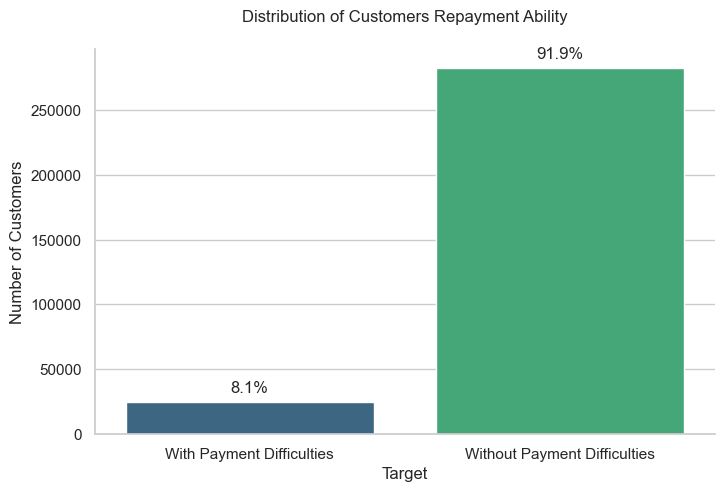

In [104]:
# Plot 'TARGET'
plt.figure(figsize=(8, 5))

# Create a count plot for the 'TARGET' variable
sns.countplot(data=app_train_eda, x='TARGET', palette='viridis')

# Set plot title and adjust its position
plt.title("Distribution of Borrowers Repayment Ability", y=1.05)

# Set axis labels
plt.xlabel("Target")
plt.ylabel('Number of Borrowers')

# Annotate each bar with the percentage of total data it represents
total_data = len(app_train_eda['TARGET'])
for p in plt.gca().patches:
    height = p.get_height()
    # Annotate each bar with the percentage, adjusting the position and font size
    plt.gca().annotate(f'{height/total_data:.1%}', (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)


sns.despine()
plt.show()

Now, regarding the use of SMOTE (Synthetic Minority Over-sampling Technique), rather than duplicating existing minority class instances, SMOTE creates synthetic samples that maintain the underlying patterns and relationships present in the original data. This prevents overfitting to the existing instances.

In [105]:
# Split data into feature data (X) and labels/targets (y)
X = train_selected.drop(['TARGET'], axis=1)
y = train_selected['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Count the number of classes before and after oversampling
original_class_distribution = y.value_counts()

# Display the class distribution before oversampling
print("Class Distribution Before SMOTE:")
print(original_class_distribution)

# Initialize SMOTE
smote = SMOTE(random_state=0)

# Perform oversampling on the training set
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Display the class distribution after oversampling
resampled_class_distribution = y_train_resampled.value_counts()
print("\nClass Distribution After SMOTE:")
print(resampled_class_distribution)

Class Distribution Before SMOTE:
0    282672
1     24816
Name: TARGET, dtype: int64

Class Distribution After SMOTE:
0    226099
1    226099
Name: TARGET, dtype: int64


# Modeling

At this stage, I'm considering four models—logistic regression, decision tree, random forest, XGBoost (XGB), and LightGBM (LGBM). The primary focus is on identifying the model with the optimal performance, with ROC AUC being the key metric. While ROC AUC is the primary criterion for model selection, if a model exhibits superior scores in other metrics and its ROC AUC can be further improved through hyperparameter tuning, it will be prioritized for selection. The goal is to choose the model that demonstrates the highest overall performance, with a particular emphasis on ROC AUC.

## Model Training

### Logistic Regression

In [106]:
# Train logistic regression model
lm, lm_y_pred_proba, lm_y_true, lm_y_pred= train_model(X_train_resampled, X_test, y_train_resampled, y_test, model='logistic', params=None)

Accuracy of logistic model: 0.6866
AUC score of logistic model: 0.7325
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.69      0.80     56573
           1       0.15      0.65      0.25      4925

    accuracy                           0.69     61498
   macro avg       0.56      0.67      0.53     61498
weighted avg       0.89      0.69      0.76     61498



### Decision Tree

In [107]:
# Train decision model
dt, dt_y_pred_proba, dt_y_true, dt_y_pred= train_model(X_train_resampled, X_test, y_train_resampled, y_test, model='decision_tree', params=None)

Accuracy of decision_tree model: 0.7917
AUC score of decision_tree model: 0.5411
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.84      0.88     56573
           1       0.12      0.24      0.16      4925

    accuracy                           0.79     61498
   macro avg       0.52      0.54      0.52     61498
weighted avg       0.86      0.79      0.82     61498



### Random Forest

In [108]:
# Train random forest model
rf, rf_y_pred_proba, rf_y_true, rf_y_pred= train_model(X_train, X_test, y_train, y_test, model='random_forest', params=None)

Accuracy of random_forest model: 0.9204
AUC score of random_forest model: 0.7194
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56573
           1       0.64      0.01      0.03      4925

    accuracy                           0.92     61498
   macro avg       0.78      0.51      0.49     61498
weighted avg       0.90      0.92      0.88     61498



### XGB

In [109]:
# Train xgb model
xgb, xgb_y_pred_proba, xgb_y_true, xgb_y_pred= train_model(X_train_resampled, X_test, y_train_resampled, y_test, model='xgb', params=None)

Accuracy of xgb model: 0.8910
AUC score of xgb model: 0.6893
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94     56573
           1       0.20      0.12      0.15      4925

    accuracy                           0.89     61498
   macro avg       0.56      0.54      0.55     61498
weighted avg       0.87      0.89      0.88     61498



### LGBM

In [110]:
# Train lgbm model
lgbm, lgbm_y_pred_proba, lgbm_y_true, lgbm_y_pred= train_model(X_train_resampled, X_test, y_train_resampled, y_test, model='lgbm', params=None)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 226099, number of negative: 226099
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3944
[LightGBM] [Info] Number of data points in the train set: 452198, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy of lgbm model: 0.8920
AUC score of lgbm model: 0.6923
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94     56573
           1       0.19      0.11      0.14      4925

    accuracy                           0.89     61498
   macro avg       0.56      0.54      0.54     61498
weighted avg       0.87      0.89      0.88     61498



## Model Evaluation



In [111]:
# Trained models
models = {'Logistic Regression': lm, 'Decision Tree': dt, 'Random Forest': rf, 'XGBoost': xgb, 'LightGBM': lgbm}

# Create a dataframe to store metric results
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Recall', 'Precision', 'ROC AUC', 'F1 Score'])

# Calculate metrics for each model
for model_name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    # Append results to the dataframe
    metrics_df = metrics_df.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'ROC AUC': roc_auc,
        'F1 Score': f1
    }, ignore_index=True)

In [112]:
# Display metrics table
metrics_df

,Model,Accuracy,Recall,Precision,ROC AUC,F1 Score
0,Logistic Regression,0.686559,0.652792,0.154709,0.732474,0.250136
1,Decision Tree,0.791652,0.242843,0.116342,0.541136,0.157317
2,Random Forest,0.920388,0.013604,0.638095,0.719360,0.026640
3,XGBoost,0.891037,0.121624,0.201412,0.689311,0.151665
4,LightGBM,0.892013,0.111269,0.194879,0.692301,0.141657


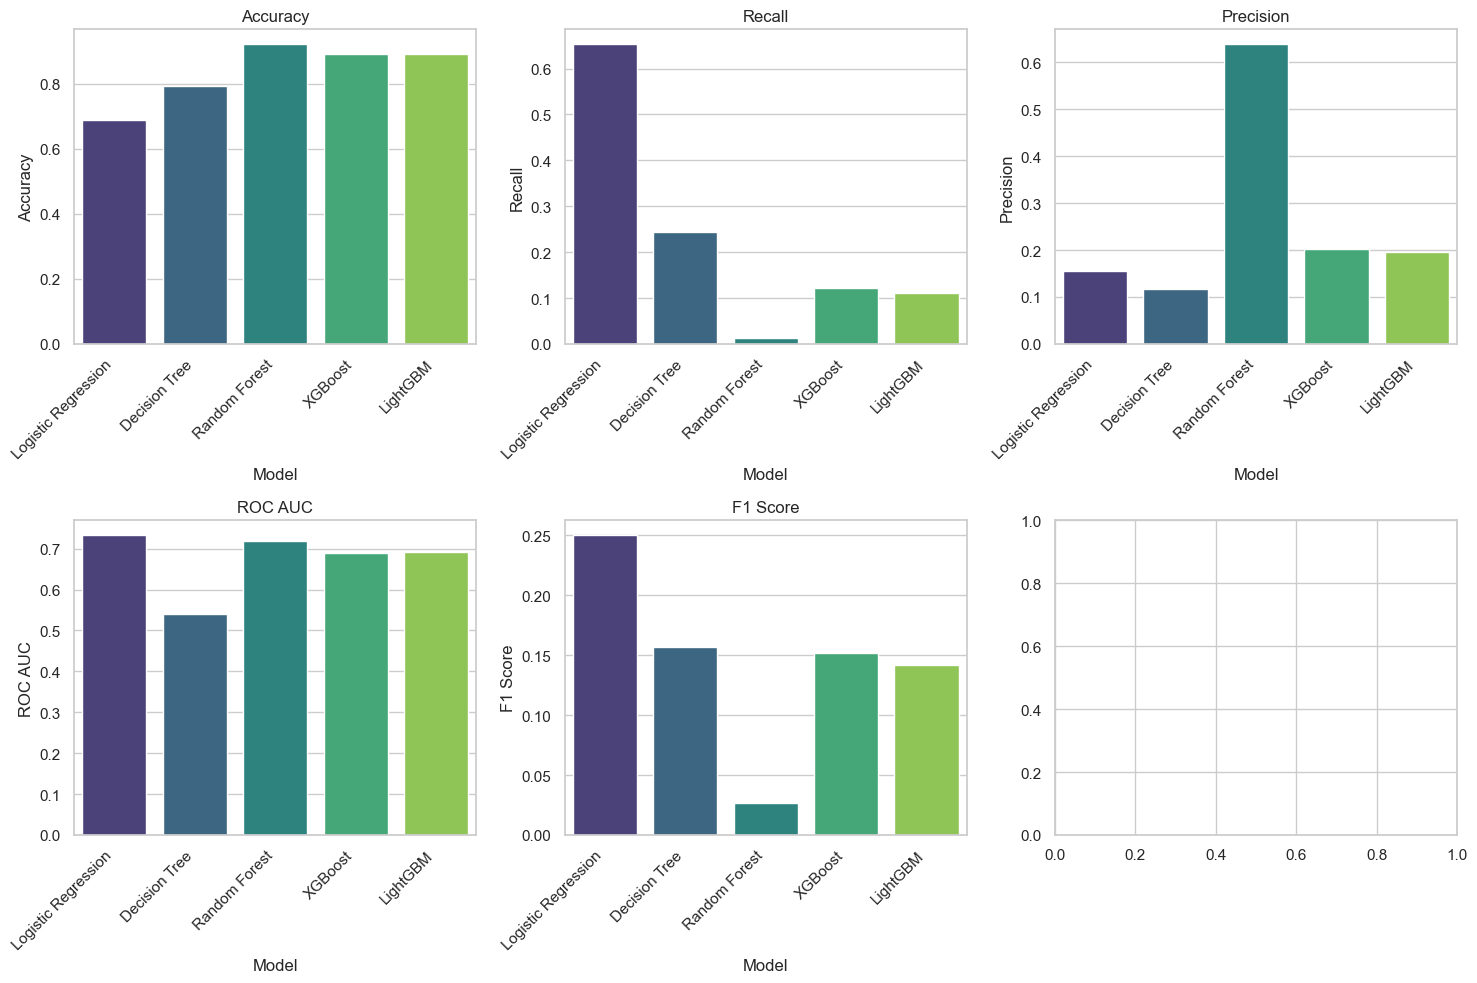

In [113]:
models = metrics_df['Model']
metrics = metrics_df.columns[1:]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)

# Plot each metric
for i, metric in enumerate(metrics):
    row, col = divmod(i, 3)
    ax = axes[row, col]
    sns.barplot(x=models, y=metrics_df[metric], ax=ax, palette='viridis')
    ax.set_title(metric)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

Given the emphasis on ensuring a positive loan experience for the underserved population and avoiding the rejection of clients capable of repayment, while also considering the overall success of the clients, the key focus should be on optimizing ROC AUC. In the context of credit risk modeling, ROC AUC measures the model's ability to distinguish between the positive and negative classes, providing a comprehensive assessment of its discriminative power.

Ensuring that clients capable of repayment are not rejected is crucial, and it's equally important to structure loans with a principal, maturity, and repayment calendar that empowers clients for success. While ROC AUC is the primary metric of interest, it's also essential to strike a balance between sensitivity and specificity, ensuring the model's overall ability to make accurate predictions across both classes. The goal is to select a model that maximizes ROC AUC while addressing the specific considerations of the underserved population and promoting positive loan outcomes.

With the considerations mentioned earlier, Logistic Regression emerges as the top-performing model. Despite having the lowest accuracy, Logistic Regression outperforms other models in terms of ROC AUC and F1 score metrics. Therefore, Logistic Regression will be selected as the model for further use. Subsequently, hyperparameter tuning will be performed to assess if its accuracy can be further improved.

## Parameter Tuning

In [114]:
# Specify hyperparameters and their possible values for tuning
param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': loguniform(1e-4, 1e4),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': randint(100, 1000),
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced'],
    'warm_start': [True, False]
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator= lm,
    param_distributions= param_distributions,
    n_iter= 10,  # Adjust the number of iterations as needed
    scoring= 'roc_auc',
    cv=5,  # Number of cross-validation folds
    random_state= 0,
    n_jobs= -1  # Use -1 to utilize all available CPU cores
)

# Fit the RandomizedSearchCV to the data
random_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters found
print("Best Parameters:", random_search.best_params_)

# Access the best model
best_logistic_regression = random_search.best_estimator_

Best Parameters: {'C': 0.24504079607415993, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 904, 'penalty': 'none', 'solver': 'newton-cg', 'warm_start': True}


## Model Retraining

Now, let's re-training logistic model using parameters that we gain from the random search.

In [115]:
params= {'C': 0.24504079607415993, 
         'class_weight': 'balanced', 
         'fit_intercept': True, 
         'max_iter': 904, 
         'penalty': 'none', 
         'solver': 'newton-cg', 
         'warm_start': True}

# Retrain logistic regression model
lm, lm_y_pred_proba, lm_y_true, lm_y_pred= train_model(X_train_resampled, X_test, y_train_resampled, y_test, model='logistic', params= params)

Accuracy of logistic model: 0.6862
AUC score of logistic model: 0.7325
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.69      0.80     56573
           1       0.15      0.65      0.25      4925

    accuracy                           0.69     61498
   macro avg       0.56      0.67      0.53     61498
weighted avg       0.89      0.69      0.76     61498



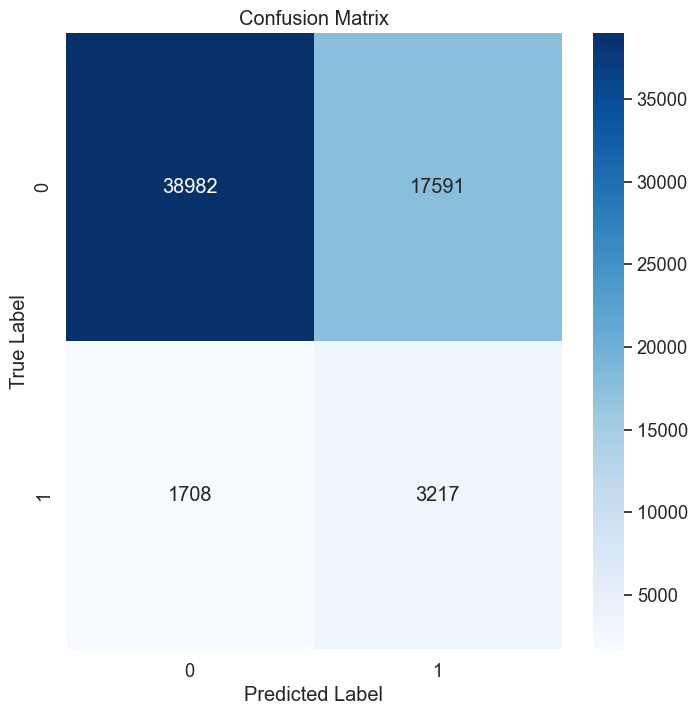

In [116]:
plot_confusion_matrix(lm_y_true, lm_y_pred, classes=None, normalize=False, title=None, cmap=plt.cm.Blues)

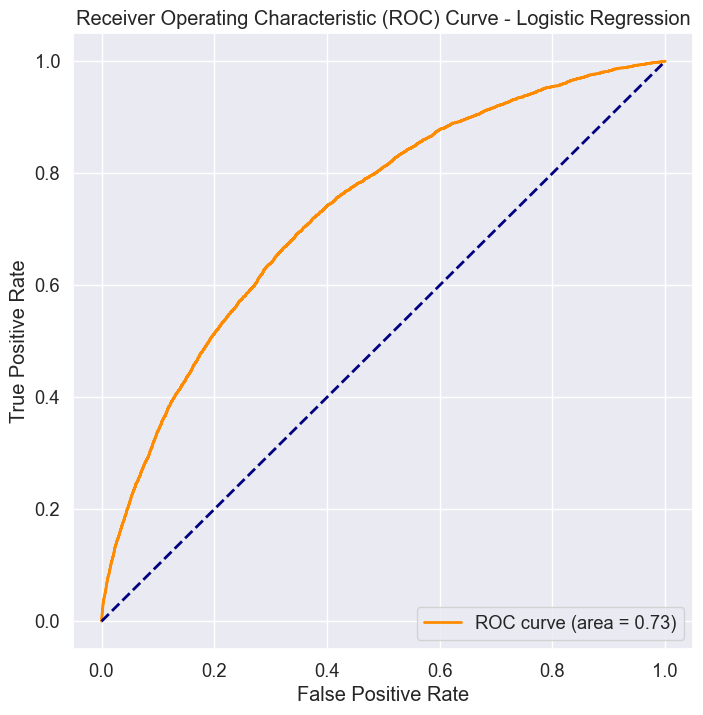

In [117]:
plot_roc_curve(lm_y_true, lm_y_pred_proba, model_name='Logistic Regression')

## Feature Importance

In [118]:
# Calculate chi-squared statistic and p-value for each feature
chi2_stat, p_val = chi2(X_train_resampled.abs(), y_train_resampled)

# Create dataframe to show result
features = X_train_resampled.columns.tolist()
df_chi2 = pd.DataFrame({'Feature': features, 'Chi2_Stat': chi2_stat, 'P_Value': p_val})
df_chi2 = df_chi2.sort_values(by='Chi2_Stat', ascending=False)

df_chi2

,Feature,Chi2_Stat,P_Value
17,AMT_GOODS_PRICE,3334.637978,0.000000e+00
1,EXT_SOURCE_2,3068.510047,0.000000e+00
2,EXT_SOURCE_3,2319.076030,0.000000e+00
10,CODE_GENDER_M,2244.098091,0.000000e+00
11,CODE_GENDER_F,1845.203858,0.000000e+00
0,EXTERNAL_SOURCE_AVG,1795.475913,0.000000e+00
21,SOCIAL_SURROUNDING_DEF,1498.900690,0.000000e+00
8,NAME_INCOME_TYPE_Working,1407.813634,4.212240e-308
9,DAYS_LAST_PHONE_CHANGE,757.186954,1.098270e-166
20,ELEVATORS_AVG,737.503347,2.092445e-162


- Importance of Chi-Squared Statistics:

The higher the Chi2_Stat, the greater the relationship between the feature and the target variable.

- Importance of P-Value:

The lower the P_Value, the more significant the relationship. Typically, if the P_Value is less than a predefined significance level (usually 0.05), we can reject the null hypothesis that there is no relationship.

In this context, features with high Chi2_Stat and low P_Value have a greater influence on the target variable.

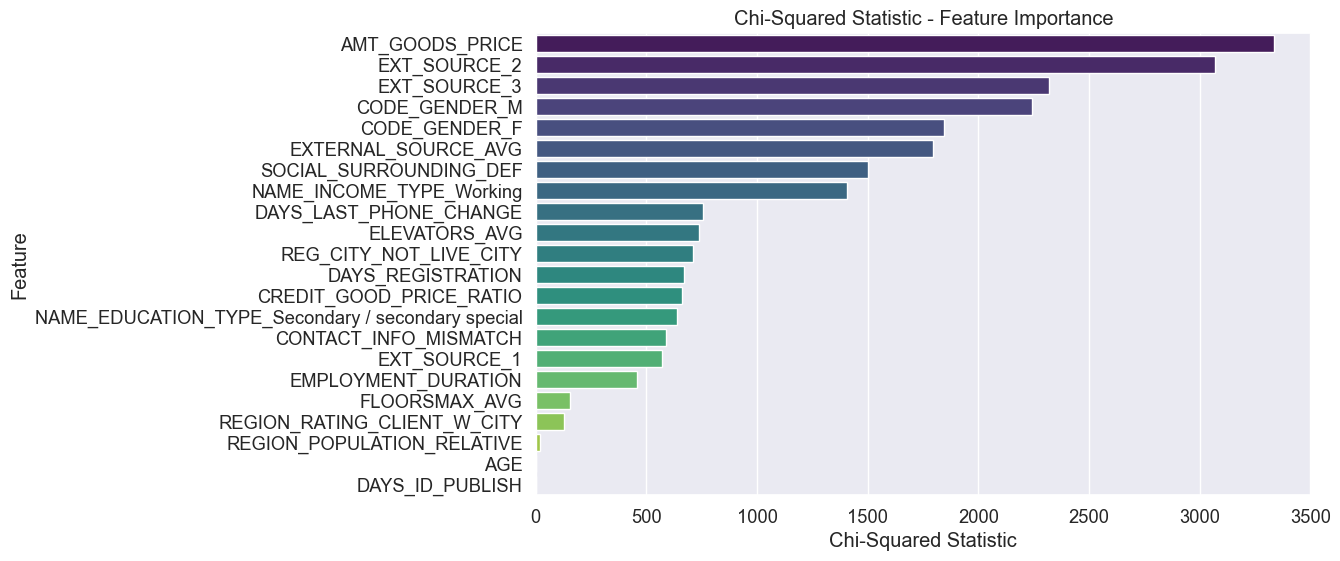

In [119]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Chi2_Stat', y='Feature', data=df_chi2, palette='viridis')
plt.title('Chi-Squared Statistic - Feature Importance')
plt.xlabel('Chi-Squared Statistic')
plt.ylabel('Feature')
plt.show()

# Business Recommendation

**1. Dynamic and Personalized Credit Terms**

**Objective**: Optimize credit terms to enhance borrower experience and repayment capabilities.

**Components**:
- Implement dynamic credit limit adjustments based on product prices.
- Tailor credit terms, repayment schedules, and interest rates for individual borrowers.

**Benefits**: Increase customer satisfaction, minimize defaults, and promote responsible borrowing.

**2. Financial Literacy Initiatives**

**Objective**: Empower borrowers with financial knowledge for informed decision-making.

**Components**:
- Launch credit education programs to enhance understanding of credit and repayment.
- Provide resources and tools for budgeting, financial planning, and debt management.

**Benefits**: Improve financial literacy, reduce payment difficulties, and foster responsible financial behavior.

**3. Customer Outreach Programs**

**Objective**: Expand engagement with underrepresented borrower groups.

**Components**:
- Targeted marketing and product development for specific income types (e.g., students, businessmen, maternity leave).
- Collaborate with educational institutions and offer specialized financial solutions.

**Benefits**: Increase market share, address diverse customer needs, and build brand loyalty.

**4. Risk Mitigation Strategies**

**Objective**: Minimize the risk of defaults and enhance overall portfolio performance.

**Components**:
- Develop comprehensive risk mitigation strategies considering various factors.
- Implement real-time monitoring and alerts for potential repayment challenges.

**Benefits**: Strengthen risk management, improve loan approval accuracy, and maintain a healthy loan portfolio.


Implementing these four key categories of recommendations collectively will contribute to a well-rounded and strategic approach in managing credit operations, fostering financial well-being among borrowers, and expanding the reach of financial services to diverse borrowers segments.